## 演習の実行方法

- プログラムの実行は、プログラムが書かれているセル毎に実行します
- 実行方法は、プログラムが書かれている左側にある「プレイボタン」（三角の印）をクリックします
- 上から順番に実行する必要があります
  - ちなみに、メニューの「ランタイム」＞「全てのセルを実行」を選択することで、全てのプログラムを実行することもできます。


# 環境設定

ここでは、プログラムに必要なライブラリを事前に読み込んでいます。

In [ ]:
from google.colab import files

import random

import io

import numpy as np
import pandas as pd

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, confusion_matrix, accuracy_score, precision_score, recall_score, mean_absolute_percentage_error
from sklearn import tree

import seaborn as sns
import graphviz

from google.colab import files

ここでは、グラフの表示設定をしています。

In [ ]:
!pip install japanize-matplotlib
import japanize_matplotlib

sns.set(font = "IPAexGothic", rc = {'figure.figsize':(12,6)}, font_scale=2)

# サラダのオーダー数の予測

## データの読み込み

- ここでは、Global & Green のオーダー数を予測するために用いるデータを読み込んでいます。
- このデータは、以下の列を含む表形式のデータとなっています。
  - 年月日
  - 最高気温(℃)
  - 降水量の合計(mm)
  - 祝休日の翌日
  - オーダー数
  - 曜日
  - 祝休日

In [ ]:
sales_csv = """
年月日,最高気温(℃),降水量の合計(mm),祝休日の翌日,オーダー数,曜日,祝休日
7/1/16,30.6,0,0,72, (Fri),0
7/2/16,31.8,0,0,70, (Sat),1
7/3/16,35.4,0,0,85, (Sun),1
7/4/16,33.8,1.5,1,84, (Mon),0
7/5/16,25.6,0,0,64, (Tue),0
7/6/16,26.9,0,0,68, (Wed),0
7/7/16,36.7,0,0,85, (Thu),0
7/8/16,29.8,0,0,73, (Fri),0
7/9/16,24.9,12.5,0,55, (Sat),1
7/10/16,31.3,0,0,73, (Sun),1
7/11/16,33.5,0,1,90, (Mon),0
7/12/16,31.8,0,0,80, (Tue),0
7/13/16,27.6,2,0,63, (Wed),0
7/14/16,32.9,21,0,77, (Thu),0
7/15/16,24,5.5,0,54, (Fri),0
7/16/16,27.7,0,0,68, (Sat),1
7/17/16,28.8,0,0,66, (Sun),1
7/18/16,33.5,0,0,83, (Mon),1
7/19/16,32.3,5,1,80, (Tue),0
7/20/16,29.9,1,0,76, (Wed),0
7/21/16,24.3,28.5,0,60, (Thu),0
7/22/16,22.7,3.5,0,60, (Fri),0
7/23/16,27.1,0,0,65, (Sat),1
7/24/16,29,0,0,69, (Sun),1
7/25/16,27.9,0,1,77, (Mon),0
7/26/16,27.4,1,0,72, (Tue),0
7/27/16,27.3,0,0,71, (Wed),0
7/28/16,31.1,0,0,72, (Thu),0
7/29/16,32.4,0,0,77, (Fri),0
7/30/16,32.9,0,0,73, (Sat),1
7/31/16,30.8,0,0,79, (Sun),1
8/1/16,31.5,2,1,91, (Mon),0
8/2/16,29.4,27,0,69, (Tue),0
8/3/16,32,16,0,77, (Wed),0
8/4/16,33,0,0,73, (Thu),0
8/5/16,33.4,0,0,73, (Fri),0
8/6/16,34.2,0,0,75, (Sat),1
8/7/16,33.6,0,0,83, (Sun),1
8/8/16,33.2,0,1,84, (Mon),0
8/9/16,37.7,0,0,85, (Tue),0
8/10/16,34,0,0,85, (Wed),0
8/11/16,32.1,0,0,71, (Thu),1
8/12/16,31.9,0,1,88, (Fri),0
8/13/16,31.8,0,0,75, (Sat),1
8/14/16,30.4,0,0,71, (Sun),1
8/15/16,30.8,0.5,1,82, (Mon),0
8/16/16,33.1,33,0,73, (Tue),0
8/17/16,34.3,14,0,82, (Wed),0
8/18/16,31.6,67,0,60, (Thu),0
8/19/16,32.3,5,0,71, (Fri),0
8/20/16,30,82,0,56, (Sat),1
8/21/16,33.5,0,0,79, (Sun),1
8/22/16,28.3,106.5,1,57, (Mon),0
8/23/16,30.4,0.5,0,74, (Tue),0
8/24/16,31.2,0,0,77, (Wed),0
8/25/16,32.7,0,0,81, (Thu),0
8/26/16,32.8,0,0,82, (Fri),0
8/27/16,27,2,0,67, (Sat),1
8/28/16,24.6,2,0,66, (Sun),1
8/29/16,30.1,16,1,83, (Mon),0
8/30/16,28.1,40.5,0,57, (Tue),0
8/31/16,31.1,0,0,72, (Wed),0
9/1/16,32.5,0,0,74, (Thu),0
9/2/16,29.8,0,0,76, (Fri),0
9/3/16,32.5,0,0,81, (Sat),1
9/4/16,31.9,3,0,76, (Sun),1
9/5/16,33,0,1,87, (Mon),0
9/6/16,32.4,0,0,76, (Tue),0
9/7/16,30.3,4.5,0,73, (Wed),0
9/8/16,30.4,11.5,0,65, (Thu),0
9/9/16,32.5,0,0,74, (Fri),0
9/10/16,31.2,0,0,79, (Sat),1
9/11/16,25.1,5,0,64, (Sun),1
9/12/16,27.7,0,1,74, (Mon),0
9/13/16,23.9,34.5,0,55, (Tue),0
9/14/16,26.6,0,0,62, (Wed),0
9/15/16,26.4,24,0,62, (Thu),0
9/16/16,24.4,3.5,0,56, (Fri),0
9/17/16,29.4,0,0,71, (Sat),1
9/18/16,26.9,2,0,70, (Sun),1
9/19/16,22.9,21.5,1,59, (Mon),0
9/20/16,20.1,91.5,0,34, (Tue),0
9/21/16,23.2,0,0,58, (Wed),0
9/22/16,20.9,56.5,0,46, (Thu),0
9/23/16,22.1,16.5,0,51, (Fri),0
9/24/16,23.9,10.5,0,61, (Sat),1
9/25/16,28.4,0,0,73, (Sun),1
9/26/16,30.1,0,1,78, (Mon),0
9/27/16,29.8,0,0,72, (Tue),0
9/28/16,30.6,0,0,77, (Wed),0
9/29/16,27.9,0,0,73, (Thu),0
9/30/16,24.7,2.5,0,64, (Fri),0
7/1/17,25.3,2,0,66, (Sat),1
7/2/17,32,1,0,80, (Sun),1
7/3/17,32.5,0,1,87, (Mon),0
7/4/17,29.9,15,0,69, (Tue),0
7/5/17,31.4,0.5,0,79, (Wed),0
7/6/17,30.7,0,0,77, (Thu),0
7/7/17,32.3,0,0,74, (Fri),0
7/8/17,33.7,0,0,76, (Sat),1
7/9/17,32.5,0,0,74, (Sun),1
7/10/17,32.1,0,1,78, (Mon),0
7/11/17,31.6,0,0,77, (Tue),0
7/12/17,33.1,0,0,79, (Wed),0
7/13/17,33.4,0,0,83, (Thu),0
7/14/17,32.4,0,0,82, (Fri),0
7/15/17,33.7,0,0,78, (Sat),1
7/16/17,34.9,0,0,78, (Sun),1
7/17/17,35,0,0,78, (Mon),1
7/18/17,32.7,10.5,1,83, (Tue),0
7/19/17,31.1,0,0,70, (Wed),0
7/20/17,32.3,0,0,75, (Thu),0
7/21/17,33.7,0,0,81, (Fri),0
7/22/17,32.5,0,0,75, (Sat),1
7/23/17,28.5,0,0,71, (Sun),1
7/24/17,32.9,0,1,90, (Mon),0
7/25/17,32.7,0,0,77, (Tue),0
7/26/17,28.2,35,0,65, (Wed),0
7/27/17,26.7,0.5,0,64, (Thu),0
7/28/17,32.3,0,0,74, (Fri),0
7/29/17,33.5,16,0,79, (Sat),1
7/30/17,29.2,0.5,0,67, (Sun),1
7/31/17,33,0,1,86, (Mon),0
8/1/17,31,6.5,0,78, (Tue),0
8/2/17,25.4,0.5,0,66, (Wed),0
8/3/17,28.9,0,0,74, (Thu),0
8/4/17,29.2,0,0,67, (Fri),0
8/5/17,31.9,0.5,0,79, (Sat),1
8/6/17,33.5,0,0,84, (Sun),1
8/7/17,33.2,9,1,88, (Mon),0
8/8/17,33.9,0,0,79, (Tue),0
8/9/17,37.1,0,0,81, (Wed),0
8/10/17,28.4,2.5,0,66, (Thu),0
8/11/17,24.8,10.5,0,63, (Fri),1
8/12/17,29.3,9.5,0,66, (Sat),1
8/13/17,31.2,0,0,79, (Sun),1
8/14/17,25.2,9.5,1,74, (Mon),0
8/15/17,26.3,43.5,0,61, (Tue),0
8/16/17,22.8,18.5,0,59, (Wed),0
8/17/17,28.2,3.5,0,69, (Thu),0
8/18/17,30.2,0,0,74, (Fri),0
8/19/17,30.3,17,0,66, (Sat),1
8/20/17,29.3,0,0,76, (Sun),1
8/21/17,31.5,0.5,1,80, (Mon),0
8/22/17,31.9,0,0,72, (Tue),0
8/23/17,33.7,0,0,76, (Wed),0
8/24/17,34.8,0,0,83, (Thu),0
8/25/17,34.9,0,0,81, (Fri),0
8/26/17,33.6,0,0,82, (Sat),1
8/27/17,30.6,0,0,71, (Sun),1
8/28/17,31.4,0,1,81, (Mon),0
8/29/17,32.2,0,0,79, (Tue),0
8/30/17,32.9,2,0,75, (Wed),0
8/31/17,24.2,8,0,56, (Thu),0
9/1/17,27.4,9.5,0,68, (Fri),0
9/2/17,24.5,14.5,0,62, (Sat),1
9/3/17,27.2,0,0,67, (Sun),1
9/4/17,22.5,8,1,61, (Mon),0
9/5/17,27.3,0.5,0,62, (Tue),0
9/6/17,22.8,9.5,0,54, (Wed),0
9/7/17,24,3,0,56, (Thu),0
9/8/17,28.2,0,0,72, (Fri),0
9/9/17,29.2,0,0,75, (Sat),1
9/10/17,29.9,0,0,72, (Sun),1
9/11/17,29.8,3,1,81, (Mon),0
9/12/17,27,4.5,0,69, (Tue),0
9/13/17,31.2,0,0,78, (Wed),0
9/14/17,31,0,0,72, (Thu),0
9/15/17,28.5,0,0,73, (Fri),0
9/16/17,22.9,8,0,60, (Sat),1
9/17/17,20.9,52,0,39, (Sun),1
9/18/17,33.3,16,0,80, (Mon),1
9/19/17,28.2,0,1,77, (Tue),0
9/20/17,25.7,0,0,68, (Wed),0
9/21/17,29.5,0,0,70, (Thu),0
9/22/17,26.1,20.5,0,55, (Fri),0
9/23/17,24,12.5,0,60, (Sat),1
9/24/17,26.3,0,0,66, (Sun),1
9/25/17,28.9,0,1,83, (Mon),0
9/26/17,28.2,0,0,74, (Tue),0
9/27/17,26.5,2.5,0,65, (Wed),0
9/28/17,24.7,45.5,0,51, (Thu),0
9/29/17,24.2,0,0,62, (Fri),0
9/30/17,24.2,0,0,56, (Sat),1
7/1/18,32,0,0,72, (Sun),1
7/2/18,33.5,0,1,79, (Mon),0
7/3/18,32.7,0,0,72, (Tue),0
7/4/18,31.2,0,0,76, (Wed),0
7/5/18,28.7,2,0,71, (Thu),0
7/6/18,25,28.5,0,59, (Fri),0
7/7/18,29.6,0,0,73, (Sat),1
7/8/18,32.2,0,0,74, (Sun),1
7/9/18,31.6,3.5,1,83, (Mon),0
7/10/18,32.8,0,0,76, (Tue),0
7/11/18,34.2,0,0,80, (Wed),0
7/12/18,30,3.5,0,69, (Thu),0
7/13/18,33.8,0,0,84, (Fri),0
7/14/18,35.4,0,0,80, (Sat),1
7/15/18,34.5,0,0,80, (Sun),1
7/16/18,34.4,0,0,78, (Mon),1
7/17/18,34.8,0,1,88, (Tue),0
7/18/18,35.3,0,0,79, (Wed),0
7/19/18,34.8,0,0,80, (Thu),0
7/20/18,34.2,0,0,78, (Fri),0
7/21/18,34.9,0,0,82, (Sat),1
7/22/18,35.6,0,0,85, (Sun),1
7/23/18,39,0,1,104, (Mon),0
7/24/18,35.3,2.5,0,77, (Tue),0
7/25/18,32.2,0,0,80, (Wed),0
7/26/18,30.7,0,0,68, (Thu),0
7/27/18,28.5,0,0,73, (Fri),0
7/28/18,28,52,0,61, (Sat),1
7/29/18,32.3,15,0,75, (Sun),1
7/30/18,31.9,0,1,86, (Mon),0
7/31/18,33.8,0,0,79, (Tue),0
8/1/18,35.1,0,0,84, (Wed),0
8/2/18,37.3,0,0,83, (Thu),0
8/3/18,35.4,0,0,80, (Fri),0
8/4/18,34.1,0,0,76, (Sat),1
8/5/18,34.7,0,0,85, (Sun),1
8/6/18,34,0,1,87, (Mon),0
8/7/18,25,4.5,0,63, (Tue),0
8/8/18,25.1,41,0,53, (Wed),0
8/9/18,32.1,4,0,79, (Thu),0
8/10/18,34.5,0,0,85, (Fri),0
8/11/18,33.6,0.5,0,76, (Sat),1
8/12/18,31.1,0,0,74, (Sun),1
8/13/18,34.1,10.5,1,82, (Mon),0
8/14/18,34.1,0,0,78, (Tue),0
8/15/18,33.1,0,0,74, (Wed),0
8/16/18,32.3,0,0,79, (Thu),0
8/17/18,30,0,0,77, (Fri),0
8/18/18,27.2,0,0,70, (Sat),1
8/19/18,28.6,0,0,74, (Sun),1
8/20/18,27.6,0,1,75, (Mon),0
8/21/18,33.6,0,0,78, (Tue),0
8/22/18,34.1,0,0,82, (Wed),0
8/23/18,33.7,0,0,78, (Thu),0
8/24/18,31.4,7.5,0,68, (Fri),0
8/25/18,35.6,0,0,87, (Sat),1
8/26/18,36,0,0,82, (Sun),1
8/27/18,35.8,16,1,90, (Mon),0
8/28/18,30.5,1,0,68, (Tue),0
8/29/18,29.2,0.5,0,65, (Wed),0
8/30/18,34,0,0,81, (Thu),0
8/31/18,35.4,1,0,80, (Fri),0
9/1/18,31.4,6,0,76, (Sat),1
9/2/18,23.7,7.5,0,58, (Sun),1
9/3/18,26.1,4,1,80, (Mon),0
9/4/18,28.7,14.5,0,71, (Tue),0
9/5/18,32,8.5,0,72, (Wed),0
9/6/18,31.5,0,0,71, (Thu),0
9/7/18,30.4,0,0,70, (Fri),0
9/8/18,33,0,0,74, (Sat),1
9/9/18,32.1,0,0,71, (Sun),1
9/10/18,30.6,38.5,1,76, (Mon),0
9/11/18,23.9,4,0,65, (Tue),0
9/12/18,24.4,0,0,64, (Wed),0
9/13/18,27.3,0,0,63, (Thu),0
9/14/18,24.9,7.5,0,63, (Fri),0
9/15/18,22.2,14.5,0,56, (Sat),1
9/16/18,27.4,0,0,63, (Sun),1
9/17/18,31.2,26,0,65, (Mon),1
9/18/18,28.1,40.5,1,68, (Tue),0
9/19/18,27.4,0,0,62, (Wed),0
9/20/18,24,40.5,0,54, (Thu),0
9/21/18,19,36,0,43, (Fri),0
9/22/18,25.8,0,0,69, (Sat),1
9/23/18,28.4,0,0,64, (Sun),1
9/24/18,28.6,1.5,1,73, (Mon),0
9/25/18,25.2,14.5,0,57, (Tue),0
9/26/18,19.9,38.5,0,44, (Wed),0
9/27/18,17.5,19,0,43, (Thu),0
9/28/18,26,0,0,65, (Fri),0
9/29/18,21.3,9.5,0,48, (Sat),1
9/30/18,27,34,0,56, (Sun),1
7/1/19,24.3,1.5,1,76, (Mon),0
7/2/19,28.1,0.5,0,63, (Tue),0
7/3/19,29.1,1,0,66, (Wed),0
7/4/19,25.2,10.5,0,58, (Thu),0
7/5/19,24.5,4.5,0,63, (Fri),0
7/6/19,23.7,14.5,0,62, (Sat),1
7/7/19,20.8,22.5,0,47, (Sun),1
7/8/19,24.8,0,1,69, (Mon),0
7/9/19,21.8,0,0,56, (Tue),0
7/10/19,24.8,0,0,59, (Wed),0
7/11/19,23.6,2,0,60, (Thu),0
7/12/19,21.9,12.5,0,51, (Fri),0
7/13/19,27.3,0.5,0,68, (Sat),1
7/14/19,22.5,39,0,52, (Sun),1
7/15/19,25,7,0,65, (Mon),1
7/16/19,22.1,33.5,1,59, (Tue),0
7/17/19,28.7,0.5,0,68, (Wed),0
7/18/19,29.7,9.5,0,69, (Thu),0
7/19/19,31.4,3.5,0,75, (Fri),0
7/20/19,29.5,0,0,70, (Sat),1
7/21/19,28.2,0,0,70, (Sun),1
7/22/19,24,0.5,1,65, (Mon),0
7/23/19,29.3,4,0,74, (Tue),0
7/24/19,31.6,6,0,78, (Wed),0
7/25/19,32.4,0,0,80, (Thu),0
7/26/19,33.1,0.5,0,82, (Fri),0
7/27/19,31.4,4,0,77, (Sat),1
7/28/19,32.3,15,0,71, (Sun),1
7/29/19,33.7,0,1,94, (Mon),0
7/30/19,33.6,0,0,76, (Tue),0
7/31/19,34.6,0,0,84, (Wed),0
8/1/19,35,0,0,86, (Thu),0
8/2/19,35.1,0,0,79, (Fri),0
8/3/19,33.7,0,0,74, (Sat),1
8/4/19,34.3,0,0,75, (Sun),1
8/5/19,34.9,0,1,95, (Mon),0
8/6/19,35,0,0,85, (Tue),0
8/7/19,35.6,0,0,78, (Wed),0
8/8/19,35.5,0,0,81, (Thu),0
8/9/19,35.6,0,0,84, (Fri),0
8/10/19,34.4,0,0,85, (Sat),1
8/11/19,35.6,0,0,80, (Sun),1
8/12/19,33.2,0.5,0,80, (Mon),1
8/13/19,35.5,0,1,93, (Tue),0
8/14/19,32.4,8.5,0,73, (Wed),0
8/15/19,32.6,20,0,77, (Thu),0
8/16/19,31.6,0,0,77, (Fri),0
8/17/19,35.5,0,0,87, (Sat),1
8/18/19,35.2,0,0,82, (Sun),1
8/19/19,32.2,0.5,1,80, (Mon),0
8/20/19,31.1,13,0,70, (Tue),0
8/21/19,31.4,3,0,74, (Wed),0
8/22/19,29.5,20,0,62, (Thu),0
8/23/19,28.5,4.5,0,70, (Fri),0
8/24/19,31.4,0,0,80, (Sat),1
8/25/19,31.1,15,0,74, (Sun),1
8/26/19,28.5,0,1,81, (Mon),0
8/27/19,29.4,6,0,74, (Tue),0
8/28/19,28.1,7,0,62, (Wed),0
8/29/19,34.6,0,0,85, (Thu),0
8/30/19,28,12,0,61, (Fri),0
8/31/19,31.7,0,0,80, (Sat),1
9/1/19,32.1,0,0,73, (Sun),1
9/2/19,31.8,0,1,86, (Mon),0
9/3/19,28.5,1.5,0,68, (Tue),0
9/4/19,26.5,0,0,60, (Wed),0
9/5/19,29.6,0,0,69, (Thu),0
9/6/19,32.9,0,0,79, (Fri),0
9/7/19,33.5,0,0,74, (Sat),1
9/8/19,33.3,8.5,0,78, (Sun),1
9/9/19,36.2,119,1,65, (Mon),0
9/10/19,35.6,0.5,0,85, (Tue),0
9/11/19,32.3,7.5,0,72, (Wed),0
9/12/19,28.7,0,0,67, (Thu),0
9/13/19,23.6,0,0,57, (Fri),0
9/14/19,25.1,0,0,65, (Sat),1
9/15/19,31.1,0.5,0,77, (Sun),1
9/16/19,25.3,28.5,0,54, (Mon),1
9/17/19,31.1,0,1,83, (Tue),0
9/18/19,24.8,9.5,0,58, (Wed),0
9/19/19,27.7,0,0,72, (Thu),0
9/20/19,27.3,0,0,62, (Fri),0
9/21/19,24.1,0,0,60, (Sat),1
9/22/19,28.5,17,0,70, (Sun),1
9/23/19,30.7,3.5,1,80, (Mon),0
9/24/19,30.9,1,0,71, (Tue),0
9/25/19,28.9,0,0,70, (Wed),0
9/26/19,27.4,0,0,66, (Thu),0
9/27/19,28.1,0,0,70, (Fri),0
9/28/19,29.6,0,0,68, (Sat),1
9/29/19,27.7,0,0,67, (Sun),1
9/30/19,29.7,0,1,78, (Mon),0
7/1/20,26.7,21,0,56, (Wed),0
7/2/20,30.8,0.5,0,76, (Thu),0
7/3/20,28.7,6,0,73, (Fri),0
7/4/20,27.7,25.5,0,59, (Sat),1
7/5/20,28.1,3.5,0,67, (Sun),1
7/6/20,26.9,40.5,1,59, (Mon),0
7/7/20,29.3,0.5,0,66, (Tue),0
7/8/20,28.5,3,0,70, (Wed),0
7/9/20,26.1,14,0,60, (Thu),0
7/10/20,28.1,0.5,0,65, (Fri),0
7/11/20,31.2,2,0,77, (Sat),1
7/12/20,32.5,0.5,0,77, (Sun),1
7/13/20,25.2,6,1,68, (Mon),0
7/14/20,23.7,6,0,62, (Tue),0
7/15/20,22,6.5,0,51, (Wed),0
7/16/20,24.6,0.5,0,59, (Thu),0
7/17/20,20.6,34.5,0,43, (Fri),0
7/18/20,22,20,0,52, (Sat),1
7/19/20,29.3,0,0,74, (Sun),1
7/20/20,31.9,0,0,75, (Mon),1
7/21/20,29,1,1,83, (Tue),0
7/22/20,29.9,0,0,68, (Wed),0
7/23/20,26,31.5,0,59, (Thu),0
7/24/20,27.2,0,0,67, (Fri),0
7/25/20,27.4,23.5,0,66, (Sat),1
7/26/20,31.2,18.5,0,72, (Sun),1
7/27/20,30.7,2,1,78, (Mon),0
7/28/20,31,2,0,77, (Tue),0
7/29/20,25.6,0,0,63, (Wed),0
7/30/20,26.5,0,0,63, (Thu),0
7/31/20,29.6,1,0,73, (Fri),0
8/1/20,31.8,0.5,0,73, (Sat),1
8/2/20,31.5,0,0,76, (Sun),1
8/3/20,32.3,0,1,80, (Mon),0
8/4/20,33.1,0,0,81, (Tue),0
8/5/20,34.2,0,0,76, (Wed),0
8/6/20,33.1,0,0,81, (Thu),0
8/7/20,35.4,0,0,84, (Fri),0
8/8/20,32.3,0,0,78, (Sat),1
8/9/20,34.7,0,0,78, (Sun),1
8/10/20,35.2,0,1,95, (Mon),0
8/11/20,37.3,0,0,86, (Tue),1
8/12/20,35.8,0.5,1,97, (Wed),0
8/13/20,36.1,21.5,0,83, (Thu),0
8/14/20,34.2,0,0,76, (Fri),0
8/15/20,36.1,0,0,87, (Sat),1
8/16/20,35.4,0,0,80, (Sun),1
8/17/20,36.5,0,1,99, (Mon),0
8/18/20,34.3,0,0,85, (Tue),0
8/19/20,34.2,0,0,84, (Wed),0
8/20/20,34.8,0,0,78, (Thu),0
8/21/20,36,0,0,86, (Fri),0
8/22/20,35.2,0,0,87, (Sat),1
8/23/20,29.4,38,0,59, (Sun),1
8/24/20,32.3,0,1,86, (Mon),0
8/25/20,32.2,0,0,72, (Tue),0
8/26/20,34,0,0,85, (Wed),0
8/27/20,33.6,0,0,82, (Thu),0
8/28/20,34.5,0,0,86, (Fri),0
8/29/20,35,0,0,79, (Sat),1
8/30/20,34.9,0,0,86, (Sun),1
8/31/20,32.6,1,1,81, (Mon),0
9/1/20,27.4,1,0,62, (Tue),0
9/2/20,32.1,7.5,0,72, (Wed),0
9/3/20,32.7,3.5,0,78, (Thu),0
9/4/20,35.1,0,0,83, (Fri),0
9/5/20,34.2,8.5,0,83, (Sat),1
9/6/20,29.5,25.5,0,61, (Sun),1
9/7/20,31.2,19,1,73, (Mon),0
9/8/20,34.2,0,0,80, (Tue),0
9/9/20,33.6,0.5,0,80, (Wed),0
9/10/20,31.7,0,0,79, (Thu),0
9/11/20,32.5,0,0,78, (Fri),0
9/12/20,27.7,14.5,0,68, (Sat),1
9/13/20,27.8,0.5,0,67, (Sun),1
9/14/20,27.2,0.5,1,74, (Mon),0
9/15/20,27.7,0.5,0,69, (Tue),0
9/16/20,28.1,2,0,66, (Wed),0
9/17/20,28.4,0,0,66, (Thu),0
9/18/20,33.4,0,0,78, (Fri),0
9/19/20,27.1,0,0,65, (Sat),1
9/20/20,23.7,0.5,0,57, (Sun),1
9/21/20,26.1,0.5,0,65, (Mon),1
9/22/20,27.7,3.5,1,74, (Tue),0
9/23/20,22.7,7.5,0,61, (Wed),0
9/24/20,22.2,10,0,53, (Thu),0
9/25/20,20.8,5.5,0,51, (Fri),0
9/26/20,20,6,0,48, (Sat),1
9/27/20,23.5,0.5,0,62, (Sun),1
9/28/20,27.4,0,1,80, (Mon),0
9/29/20,23.1,0,0,64, (Tue),0
9/30/20,25.4,0,0,60, (Wed),0
"""

In [ ]:
sales = pd.read_csv(io.StringIO(sales_csv), header=0)

- ここでは、読み込んだ Global & Green の売上データを一部表示しています。
  - 全部で 460 件ありますが、最初と最後の 5 件ずつ表示しています。

In [ ]:
sales

年月日  最高気温(℃)  降水量の合計(mm)  祝休日の翌日  オーダー数      曜日  祝休日
0     7/1/16     30.6         0.0       0     72   (Fri)    0
1     7/2/16     31.8         0.0       0     70   (Sat)    1
2     7/3/16     35.4         0.0       0     85   (Sun)    1
3     7/4/16     33.8         1.5       1     84   (Mon)    0
4     7/5/16     25.6         0.0       0     64   (Tue)    0
..       ...      ...         ...     ...    ...     ...  ...
455  9/26/20     20.0         6.0       0     48   (Sat)    1
456  9/27/20     23.5         0.5       0     62   (Sun)    1
457  9/28/20     27.4         0.0       1     80   (Mon)    0
458  9/29/20     23.1         0.0       0     64   (Tue)    0
459  9/30/20     25.4         0.0       0     60   (Wed)    0

[460 rows x 7 columns]

### データのダウンロード

- ここでは、上で読み込んだデータを csv 形式でお手元の PC にダウンロードします。
- お使いの PC にデータをダウンロードすることで Excel などアプリケーションを使ってデータの中身を直接ご覧いただけます。
- 但し、このデータを使った分析はこのノートブック上で進めますので、ダウンロードしたデータは利用しません。

In [ ]:
_filename =  "サラダの売上データ.csv"
sales.to_csv(_filename, encoding = 'utf-8-sig') 
files.download(_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## データの可視化

- まずは、まずは読み込んだデータの概要をグラフとして可視化することで確認してみましょう。
- データの項目（列）毎にデータの様子をヒストグラムで確認してみます。
  - ヒストグラムとは、横軸に階級（数値の区間）を、縦軸には度数（階級に属するデータの個数）をとった、データの分布の形が視覚的に理解しやすいグラフです。
- また、項目（列）毎に「オーダー数」との関係を散布図もしくは箱ひげ図で確認してみます。
  - 散布図とは、1組のデータの2つの要素の関係をわかりやすく見るためのグラフです。
  - 箱ひげ図とは、平均に加えて、最大値、最小値などデータのばらつきをわかりやすく表現するグラフです。



### 最高気温

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


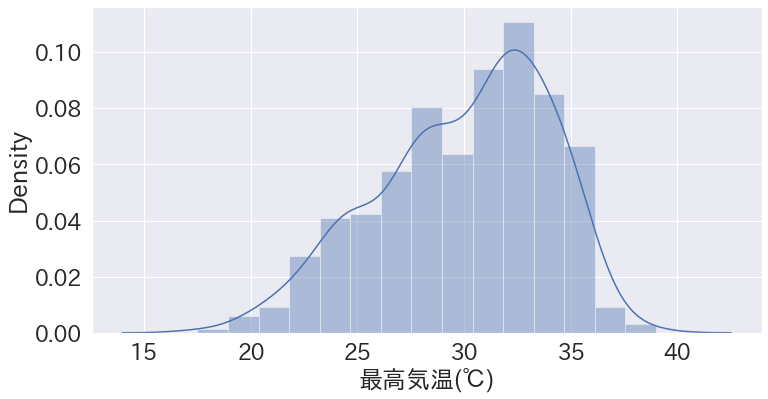

In [ ]:
sns.distplot(sales['最高気温(℃)']) 

- このヒストグラムからは、最高気温は30℃を超える日が多いことがわかります。

### 最高気温(℃) x オーダー数

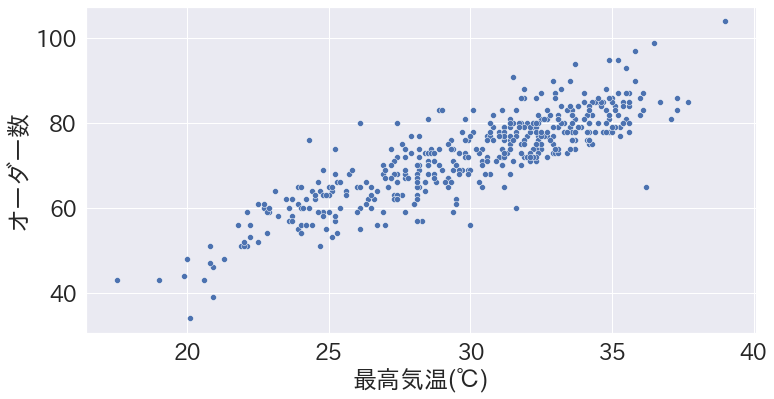

In [ ]:
sns.scatterplot(data=sales, x='最高気温(℃)', y='オーダー数')

- この散布図からは、「最高気温」が高くなると「オーダー数」も多くなる様子がかなりはっきりと伺えます。
- したがって、  「最高気温」は「オーダー数」の予測に有用そうだと見当がつきます。

### 降水量の合計(mm)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


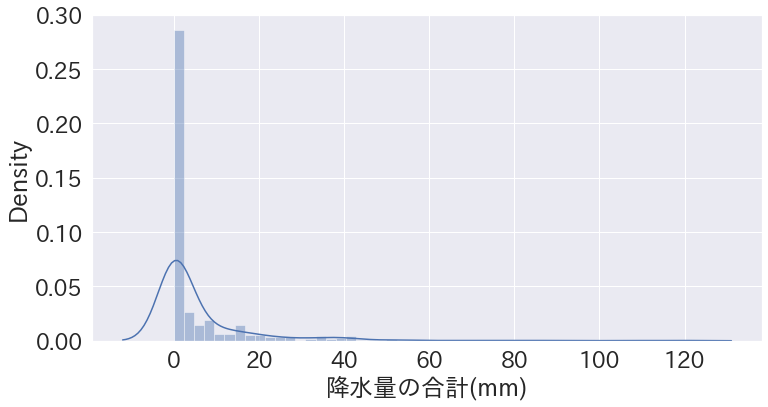

In [ ]:
sns.distplot(sales['降水量の合計(mm)']) 

このヒストグラムからは、「降水量」はまったくないか、少ない日が多く、特異的に 100 mm を越す日があることがわかります。

### 降水量の合計(mm) x オーダー数

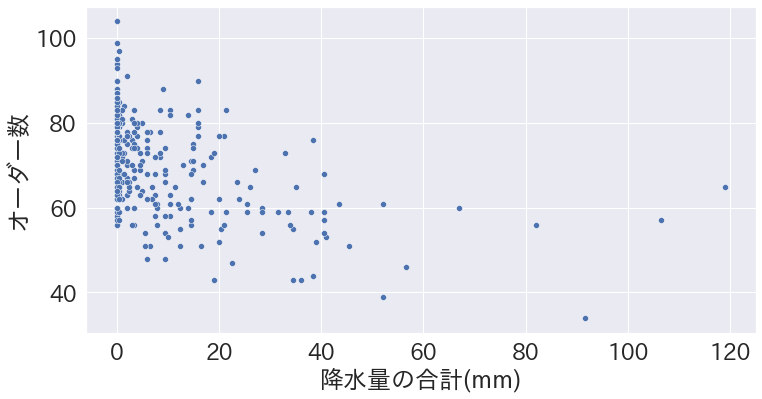

In [ ]:
sns.scatterplot(data=sales, x='降水量の合計(mm)', y='オーダー数')

- この散布図からは、「降水量」が多くなると、「オーダー数」が減少するような様子が伺えます。
- したがって、 「降水量の合計」は「オーダー数」の予測に有用そうだと見当がつきます。

### 祝休日の翌日 x オーダー数

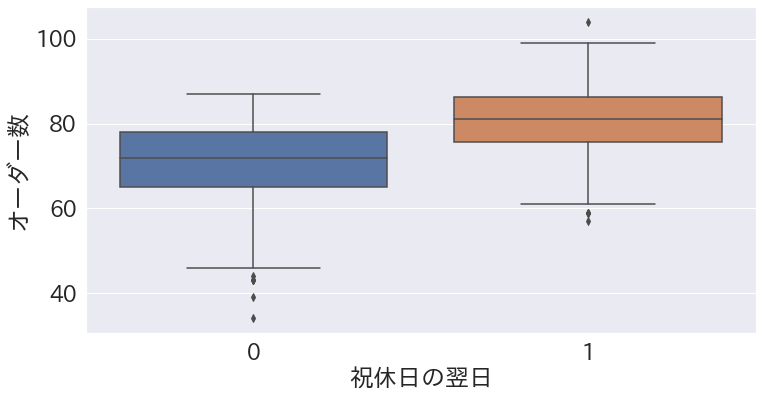

In [ ]:
sns.boxplot(data=sales, x='祝休日の翌日', y='オーダー数')

- この箱ひげ図からは、「祝休日の翌日」ではない日（0）より、「祝休日の翌日」（1)である日の方が、「オーダー数」が多い様子が伺えます。
  - 例えば、それぞれの場合の平均値は、２段に重なった箱の真ん中の横棒の位置で確認できます。
- したがって、 「祝休日の翌日」は「オーダー数」の予測に有用そうだと見当がつきます。

### 曜日 x オーダー数

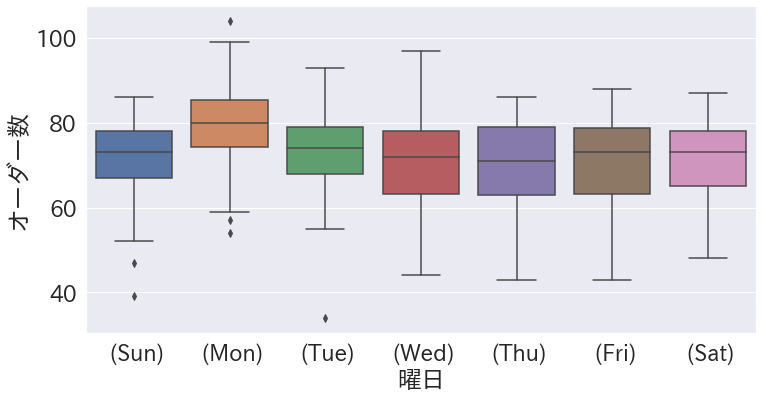

In [ ]:
sns.boxplot(data=sales, x='曜日', y='オーダー数', order=[' (Sun)', ' (Mon)', ' (Tue)', ' (Wed)', ' (Thu)', ' (Fri)', ' (Sat)'])

- この箱ひげ図からは、月曜日を除いて「曜日」毎の「オーダー数」にはそれほどの違いがない様子が伺えます。

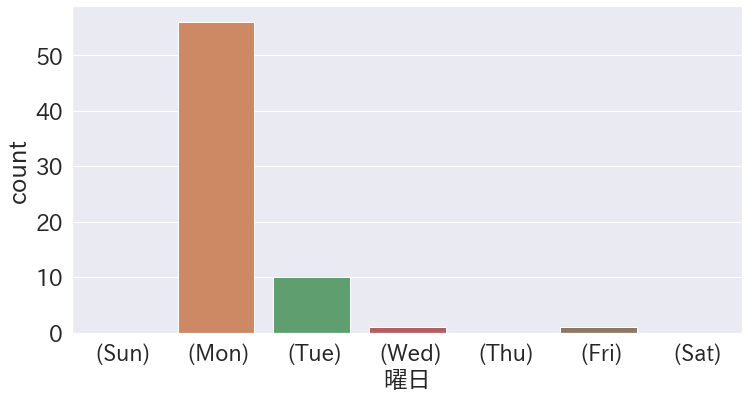

In [ ]:
sns.countplot(x="曜日", data=sales[sales['祝休日の翌日'] == 1], order=[' (Sun)', ' (Mon)', ' (Tue)', ' (Wed)', ' (Thu)', ' (Fri)', ' (Sat)'])

- この図では、「曜日」別の「祝休日の翌日」のデータの件数をカウントしています。
- ここからは、月曜日は「祝休日の翌日」になることが特に多いので、「曜日」は「オーダー数」の予測にあまり有用そうではなく、「曜日」の「オーダー数」に対する影響は、「祝休日の翌日」による影響によって表現できそうです。

## X （特徴量）と y （目的変数）の作成

### X

X（特徴量）には、データの可視化で「オーダー数」の予測に有用ではないかと見当をつけた、以下の 3 つの変数を利用します。
- 最高気温(℃)	
- 降水量の合計(mm)	
- 祝休日の翌日

In [ ]:
X = sales[['最高気温(℃)','降水量の合計(mm)', '祝休日の翌日']]

In [ ]:
X

最高気温(℃)  降水量の合計(mm)  祝休日の翌日
0       30.6         0.0       0
1       31.8         0.0       0
2       35.4         0.0       0
3       33.8         1.5       1
4       25.6         0.0       0
..       ...         ...     ...
455     20.0         6.0       0
456     23.5         0.5       0
457     27.4         0.0       1
458     23.1         0.0       0
459     25.4         0.0       0

[460 rows x 3 columns]

### y

y（目的変数）には「オーダー数」を使います。

In [ ]:
y = sales['オーダー数']

In [ ]:
y

0      72
1      70
2      85
3      84
4      64
       ..
455    48
456    62
457    80
458    64
459    60
Name: オーダー数, Length: 460, dtype: int64

## 予測モデルの学習

ライブラリを利用して、X から y を予測する線形回帰モデルを作成します。

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X, y)

LinearRegression()

## 作成したモデルの解釈

### 決定係数

In [ ]:
round(lr_model.score(X, y), 2)

0.89

- 決定係数はデータに対する、ここで推定した線形回帰モデルの当てはまりの良さを表します。
- 1 に近いほど、モデルが実際のデータに当てはまっていることを表します。
- ここでは、決定係数が十分に大きいので、このモデルが X と y の関係をよく説明していると言えます。

### 予測誤差


In [ ]:
# MAPE　（平均絶対パーセント誤差）
mape = mean_absolute_percentage_error(y, lr_model.predict(X))

In [ ]:
round(mape * 100, 2)

4.12

これより、作成したモデルは、平均的にサラダのオーダー数の個数を 4.12％の誤差で予測できることがわかります。

In [ ]:
# RMSE（平均二乗偏差）
rmse = np.sqrt(mean_squared_error(y, lr_model.predict(X))) 

In [ ]:
round(rmse, 2)

3.35

これより、作成したモデルは、平均的にサラダのオーダー数の個数を 3.35 個の誤差で予測できることがわかります。

### 作成したモデルの係数

#### 切片

In [ ]:
round(lr_model.intercept_, 2)

13.43

これより
- 最高気温(℃)
- 降水量の合計(mm)
- 祝休日の翌日

にとは無関係に、ベースとなるオーダー数は 13.43 個であると予測していることがわかります。

In [ ]:
coef_highest_temp, coef_precipitation, coef_after_holidays = lr_model.coef_

#### 最高気温(℃)

In [ ]:
round(coef_highest_temp, 2)

1.96

これにより、「最高気温」が 1℃ 上がる毎に、1.96 個ずつ「オーダー数」が増えると予測していることがわかります。

#### 降水量の合計(mm)

In [ ]:
round(coef_precipitation, 2)

-0.21

これにより、「降雨量の合計」が 1 mm 増える毎に、-0.21 個ずつ「オーダー数」が増えると予測していることがわかります。

#### 祝休日の翌日

In [ ]:
round(coef_after_holidays, 2)

8.49

これにより、「祝休日の翌日」の場合は、「祝休日の翌日」ではない場合に比べて、8.49 個「オーダー数」が増えると予測していることがわかります。

## 明日の売り上げを予測してみよう！

### まあまあ暑くて、雨が降らない、前日が祝休日

- 最高気温(℃)
  - 30
- 降水量の合計(mm)
  - 0
- 祝休日の翌日
  - 1

In [ ]:
lr_model.predict([[30.0,	0.0,	1]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([80.69719232])

「まあまあ暑くて、雨が降らない、前日が祝休日」は、オーダー数の予想は約 81 個のようです。

### ちょっと涼しい、雨が降る、前日が祝休日でない日

- 最高気温(℃)
  - 22
- 降水量の合計(mm)
  - 50
- 祝休日の翌日
  - 0

In [ ]:
lr_model.predict([[22.0,	50.0,	0]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([46.10669604])

「ちょっと涼しい、雨が降る、前日が祝休日でない日」は、オーダー数の予想は約 46 個のようです。

### 明日のオーダー数予想

- 最高気温(℃)
  - 28
- 降水量の合計(mm)
  - 0
- 祝休日の翌日
  - 0

In [ ]:
lr_model.predict([[28.0,	0.0,	0]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  "X does not have valid feature names, but"


array([68.29044463])

明日は、オーダー数の予想は約 68 個のようです。

# 無断キャンセルユーザーの分類

In [ ]:
from datetime import datetime, date, time, timedelta
import statistics

random.seed(1)

w_list = ['月', '火', '水', '木', '金', '土', '日']
daily_online_orders_list = []

for day in range(1, 31 + 1):

  order_per_day = int(random.normalvariate(40, 10))
  
  reserve_date = date(2022, 1, day)
  reserve_times = [time(random.randint(7, 20), random.randint(0, 59), random.randint(0, 59)) for x in range(0, order_per_day)]
  
  # order_date = [1 if random.randint(0, 100) < 80 else 0 for x in range(0, order_per_day)]

  hour_deltas = [int(random.expovariate(0.1)) for x in range(0, order_per_day)]

  order_datetimes = [datetime.combine(reserve_date, reserve_time) - timedelta(hours=hour_delta) for reserve_time, hour_delta in zip(reserve_times, hour_deltas)]

  order_dates = [x.date() for x in order_datetimes]
  order_times = [x.time() for x in order_datetimes]

  total_price = [x if x > 800 else 800 for x in [int(random.normalvariate(1500, 400) / 100) * 100 for x in range(0, order_per_day)]]
  within_area = [1 if random.randint(0, 100) < 80 else 0 for x in range(0, order_per_day)]

  daily_online_orders = pd.DataFrame(
    { 
      '予約日付' : reserve_date,
      '予約曜日' : w_list[reserve_date.weekday()],
      '予約時間' : reserve_times,
      '予約時間（時）' : [x.hour for x in reserve_times],
      '注文日付' : order_dates,
      '注文曜日' : [w_list[x.weekday()]  for x in order_dates],
      '注文時間' : order_times,
      '予約注文時間差' : hour_deltas, 
      '合計金額' : total_price,
      '地域内からの注文' : within_area,
                         })
  daily_online_orders_list.append(daily_online_orders)

_online_orders = pd.concat(daily_online_orders_list, ignore_index=True)

def get_score(row):
  strong = 0.033
  medium = 0.06
  weak = 1.0
  score = 0
  if row['地域内からの注文'] == 0:
    score = score + int(random.expovariate(strong))
  if row['予約時間'].hour == 20:
    score = score + int(random.expovariate(strong))
  if row['予約曜日'] in ['月', '火', '水', '木', '金']:
    score = score + int(random.expovariate(medium))
  if row['合計金額'] <= 1500:
    score = score + int(random.expovariate(weak))
  if row['予約注文時間差'] > 23:
    score = score + int(random.expovariate(medium))
  if row['予約注文時間差'] < 3:
    score = score - int(random.expovariate(weak))
  return score

_online_orders['スコア'] = _online_orders.apply(lambda row: get_score(row), axis=1)
_online_orders['受け取りなし'] = _online_orders.apply(lambda row: 1 if row['スコア'] > 50 else 0, axis=1)

### 結果を眺める

In [ ]:
_online_orders

予約日付 予約曜日      予約時間  予約時間（時）  ...  合計金額 地域内からの注文 スコア  受け取りなし
0     2022-01-01    土  14:48:28       14  ...  1300        1   0       0
1     2022-01-01    土  14:41:24       14  ...  1600        1   0       0
2     2022-01-01    土  19:13:06       19  ...  1500        1   1       0
3     2022-01-01    土  14:01:57       14  ...   900        1   1       0
4     2022-01-01    土  20:24:27       20  ...  1400        0  65       1
...          ...  ...       ...      ...  ...   ...      ...  ..     ...
1187  2022-01-31    月  08:45:48        8  ...  2100        1  -1       0
1188  2022-01-31    月  13:03:00       13  ...  1800        1  32       0
1189  2022-01-31    月  18:12:54       18  ...  1300        1   7       0
1190  2022-01-31    月  12:12:06       12  ...  1100        0  28       0
1191  2022-01-31    月  18:02:56       18  ...  1200        1  10       0

[1192 rows x 12 columns]

In [ ]:
del _online_orders['予約時間（時）']
del _online_orders['予約注文時間差']
del _online_orders['スコア']

### 2022年1月のオンライン注文数

In [ ]:
_online_orders.shape[0]

1192

### 2022年1月のオンライン注文のうちキャンセル件数

In [ ]:
_online_orders[_online_orders['受け取りなし'] == 1].shape

(118, 9)

In [ ]:
print(_online_orders.to_csv(index=False))

予約日付,予約曜日,予約時間,注文日付,注文曜日,注文時間,合計金額,地域内からの注文,受け取りなし
2022-01-01,土,14:48:28,2022-01-01,土,07:48:28,1300,1,0
2022-01-01,土,14:41:24,2021-12-31,金,19:41:24,1600,1,0
2022-01-01,土,19:13:06,2022-01-01,土,17:13:06,1500,1,0
2022-01-01,土,14:01:57,2022-01-01,土,07:01:57,900,1,0
2022-01-01,土,20:24:27,2021-12-31,金,14:24:27,1400,0,1
2022-01-01,土,16:48:49,2022-01-01,土,08:48:49,1400,1,0
2022-01-01,土,07:44:28,2022-01-01,土,01:44:28,1300,1,0
2022-01-01,土,11:46:51,2022-01-01,土,08:46:51,1200,1,0
2022-01-01,土,10:37:06,2022-01-01,土,03:37:06,2000,1,0
2022-01-01,土,12:01:01,2021-12-31,金,05:01:01,900,0,0
2022-01-01,土,07:41:34,2022-01-01,土,07:41:34,1600,1,0
2022-01-01,土,07:56:24,2021-12-31,金,16:56:24,1900,1,0
2022-01-01,土,17:13:27,2022-01-01,土,00:13:27,1500,1,0
2022-01-01,土,18:01:33,2021-12-31,金,21:01:33,1500,1,0
2022-01-01,土,10:48:28,2021-12-31,金,21:48:28,1600,0,0
2022-01-01,土,14:35:14,2021-12-31,金,22:35:14,1500,1,0
2022-01-01,土,12:14:43,2022-01-01,土,05:14:43,1500,0,0
2022-01-01,土,10:48:29,2022-01-01,土,02:48:29,1800,1

## データの読み込み

- ここでは、Global & Green のある店舗の2022年1月のオンライン予約データを読み込んでいます。
- このデータを用いて、オンライン予約のうちで無断キャンセルとなる／ならないデータの分類モデルを構築します。
- このデータは、以下の列を含む表形式のデータとなっています。
  - 予約日付
  - 予約曜日
  - 予約時間
  - 注文日付
  - 注文曜日
  - 注文時間
  - 合計金額
  - 地域内からの注文
  - 受け取り（あり）なし

In [ ]:
online_orders_csv = """
予約日付,予約曜日,予約時間,注文日付,注文曜日,注文時間,合計金額,地域内からの注文,受け取りなし
2022-01-01,土,14:48:28,2022-01-01,土,07:48:28,1300,1,0
2022-01-01,土,14:41:24,2021-12-31,金,19:41:24,1600,1,0
2022-01-01,土,19:13:06,2022-01-01,土,17:13:06,1500,1,0
2022-01-01,土,14:01:57,2022-01-01,土,07:01:57,900,1,0
2022-01-01,土,20:24:27,2021-12-31,金,14:24:27,1400,0,1
2022-01-01,土,16:48:49,2022-01-01,土,08:48:49,1400,1,0
2022-01-01,土,07:44:28,2022-01-01,土,01:44:28,1300,1,0
2022-01-01,土,11:46:51,2022-01-01,土,08:46:51,1200,1,0
2022-01-01,土,10:37:06,2022-01-01,土,03:37:06,2000,1,0
2022-01-01,土,12:01:01,2021-12-31,金,05:01:01,900,0,0
2022-01-01,土,07:41:34,2022-01-01,土,07:41:34,1600,1,0
2022-01-01,土,07:56:24,2021-12-31,金,16:56:24,1900,1,0
2022-01-01,土,17:13:27,2022-01-01,土,00:13:27,1500,1,0
2022-01-01,土,18:01:33,2021-12-31,金,21:01:33,1500,1,0
2022-01-01,土,10:48:28,2021-12-31,金,21:48:28,1600,0,0
2022-01-01,土,14:35:14,2021-12-31,金,22:35:14,1500,1,0
2022-01-01,土,12:14:43,2022-01-01,土,05:14:43,1500,0,0
2022-01-01,土,10:48:29,2022-01-01,土,02:48:29,1800,1,0
2022-01-01,土,11:59:01,2022-01-01,土,06:59:01,1800,1,0
2022-01-01,土,13:53:58,2022-01-01,土,13:53:58,1400,1,0
2022-01-01,土,15:59:41,2021-12-31,金,19:59:41,1500,1,0
2022-01-01,土,08:11:40,2022-01-01,土,00:11:40,1300,1,0
2022-01-01,土,18:55:18,2022-01-01,土,16:55:18,1700,1,0
2022-01-01,土,08:47:21,2022-01-01,土,01:47:21,1200,1,0
2022-01-01,土,18:45:32,2022-01-01,土,12:45:32,1600,1,0
2022-01-01,土,13:32:53,2022-01-01,土,09:32:53,1400,1,0
2022-01-01,土,17:12:19,2022-01-01,土,13:12:19,1700,1,0
2022-01-01,土,11:37:56,2022-01-01,土,04:37:56,800,1,0
2022-01-01,土,14:54:32,2022-01-01,土,05:54:32,800,1,0
2022-01-01,土,13:37:54,2022-01-01,土,04:37:54,1700,1,0
2022-01-01,土,07:30:15,2022-01-01,土,01:30:15,1600,1,0
2022-01-01,土,18:51:25,2022-01-01,土,18:51:25,800,0,0
2022-01-01,土,13:42:11,2022-01-01,土,11:42:11,1900,1,0
2022-01-01,土,12:35:56,2022-01-01,土,11:35:56,1300,0,1
2022-01-01,土,18:49:43,2022-01-01,土,10:49:43,800,1,0
2022-01-01,土,18:23:05,2021-12-31,金,23:23:05,1500,0,0
2022-01-01,土,14:42:32,2021-12-31,金,22:42:32,1800,1,0
2022-01-01,土,08:49:10,2021-12-31,金,17:49:10,1800,0,0
2022-01-01,土,15:53:25,2021-12-31,金,23:53:25,1300,1,0
2022-01-01,土,12:31:46,2022-01-01,土,10:31:46,1200,1,0
2022-01-01,土,07:30:02,2021-12-31,金,13:30:02,2000,1,0
2022-01-01,土,11:45:54,2022-01-01,土,00:45:54,1400,1,0
2022-01-01,土,16:37:37,2022-01-01,土,16:37:37,1400,1,0
2022-01-01,土,13:41:10,2022-01-01,土,13:41:10,1100,1,0
2022-01-01,土,09:32:14,2022-01-01,土,09:32:14,1600,1,0
2022-01-01,土,07:49:12,2021-12-31,金,17:49:12,1900,1,0
2022-01-02,日,08:48:28,2022-01-01,土,10:48:28,1600,1,0
2022-01-02,日,08:41:36,2022-01-02,日,07:41:36,1500,1,0
2022-01-02,日,17:21:14,2022-01-01,土,17:21:14,1300,1,0
2022-01-02,日,13:19:02,2022-01-02,日,13:19:02,1100,1,0
2022-01-02,日,12:11:20,2022-01-02,日,09:11:20,1800,1,0
2022-01-02,日,19:54:37,2022-01-01,土,20:54:37,1300,1,0
2022-01-02,日,11:15:21,2022-01-01,土,19:15:21,1500,1,0
2022-01-02,日,08:34:39,2022-01-01,土,09:34:39,1600,1,0
2022-01-02,日,16:51:38,2022-01-01,土,22:51:38,1900,1,0
2022-01-02,日,08:15:14,2022-01-01,土,19:15:14,1100,1,0
2022-01-02,日,07:51:15,2022-01-01,土,20:51:15,1400,1,0
2022-01-02,日,13:04:17,2022-01-02,日,12:04:17,1300,1,0
2022-01-02,日,15:55:04,2022-01-02,日,10:55:04,1000,1,0
2022-01-02,日,18:04:01,2022-01-02,日,17:04:01,1500,1,0
2022-01-02,日,17:00:18,2022-01-02,日,05:00:18,1800,1,0
2022-01-02,日,19:50:22,2022-01-02,日,08:50:22,2300,1,0
2022-01-02,日,14:30:55,2022-01-02,日,12:30:55,1200,0,0
2022-01-02,日,20:09:06,2022-01-02,日,20:09:06,1900,1,0
2022-01-02,日,15:49:50,2022-01-01,土,06:49:50,1200,1,0
2022-01-02,日,12:04:32,2022-01-01,土,20:04:32,1000,1,0
2022-01-02,日,17:11:11,2022-01-02,日,10:11:11,1900,1,0
2022-01-02,日,19:09:09,2022-01-02,日,12:09:09,1200,0,0
2022-01-02,日,20:55:20,2022-01-02,日,01:55:20,800,1,1
2022-01-02,日,11:06:45,2022-01-02,日,05:06:45,2000,1,0
2022-01-02,日,15:53:58,2022-01-02,日,10:53:58,1800,1,0
2022-01-02,日,16:18:08,2022-01-02,日,12:18:08,1000,1,0
2022-01-03,月,17:38:15,2022-01-03,月,15:38:15,900,0,0
2022-01-03,月,20:16:13,2022-01-03,月,13:16:13,800,0,0
2022-01-03,月,09:18:09,2022-01-02,日,22:18:09,1600,1,0
2022-01-03,月,15:12:17,2022-01-03,月,07:12:17,1200,1,1
2022-01-03,月,11:37:48,2022-01-02,日,00:37:48,1200,1,0
2022-01-03,月,11:53:43,2022-01-03,月,07:53:43,2300,1,0
2022-01-03,月,14:50:55,2022-01-03,月,05:50:55,1400,1,0
2022-01-03,月,19:54:10,2022-01-02,日,07:54:10,1000,0,0
2022-01-03,月,15:22:31,2022-01-03,月,03:22:31,1500,1,0
2022-01-03,月,13:54:07,2022-01-02,日,03:54:07,1700,1,0
2022-01-03,月,19:13:36,2022-01-03,月,19:13:36,1300,1,0
2022-01-03,月,13:13:18,2022-01-01,土,18:13:18,1000,1,0
2022-01-03,月,19:06:57,2022-01-03,月,17:06:57,1700,1,0
2022-01-03,月,19:01:07,2022-01-02,日,09:01:07,1500,1,1
2022-01-03,月,16:47:00,2022-01-03,月,13:47:00,2200,1,0
2022-01-03,月,15:18:43,2022-01-03,月,15:18:43,1900,1,0
2022-01-03,月,19:46:41,2022-01-03,月,07:46:41,1200,0,0
2022-01-03,月,09:04:32,2022-01-03,月,08:04:32,2100,1,0
2022-01-03,月,12:36:51,2022-01-02,日,21:36:51,2300,1,0
2022-01-03,月,11:27:32,2022-01-03,月,06:27:32,1400,1,0
2022-01-03,月,17:22:48,2022-01-03,月,14:22:48,1400,1,0
2022-01-03,月,15:20:00,2022-01-03,月,14:20:00,1400,1,0
2022-01-03,月,08:28:45,2022-01-03,月,08:28:45,800,1,0
2022-01-03,月,14:22:19,2022-01-03,月,00:22:19,1100,1,0
2022-01-03,月,15:25:21,2022-01-03,月,15:25:21,2000,1,0
2022-01-03,月,19:46:43,2022-01-02,日,19:46:43,1400,1,0
2022-01-03,月,16:31:07,2022-01-03,月,00:31:07,1300,0,1
2022-01-03,月,17:58:24,2022-01-03,月,12:58:24,1100,1,0
2022-01-03,月,13:13:35,2022-01-03,月,02:13:35,1200,1,0
2022-01-03,月,07:17:40,2022-01-03,月,04:17:40,1100,1,0
2022-01-03,月,16:46:56,2022-01-03,月,10:46:56,1200,1,0
2022-01-03,月,18:53:46,2022-01-03,月,15:53:46,1500,1,0
2022-01-03,月,15:12:59,2022-01-03,月,14:12:59,1400,1,0
2022-01-03,月,14:38:53,2022-01-03,月,07:38:53,1400,0,1
2022-01-03,月,15:26:59,2022-01-03,月,12:26:59,1200,1,0
2022-01-03,月,18:45:19,2022-01-03,月,17:45:19,1300,0,0
2022-01-03,月,18:10:28,2022-01-03,月,10:10:28,1800,1,0
2022-01-03,月,16:42:33,2022-01-03,月,16:42:33,1200,0,0
2022-01-04,火,14:24:21,2022-01-04,火,12:24:21,1200,0,0
2022-01-04,火,17:17:16,2022-01-04,火,13:17:16,1900,1,0
2022-01-04,火,17:40:15,2022-01-04,火,14:40:15,1600,1,0
2022-01-04,火,10:03:37,2022-01-04,火,05:03:37,1500,0,0
2022-01-04,火,19:37:11,2022-01-04,火,18:37:11,2100,1,0
2022-01-04,火,12:27:38,2022-01-04,火,12:27:38,1400,1,0
2022-01-04,火,18:35:40,2022-01-04,火,15:35:40,1200,1,0
2022-01-04,火,15:03:57,2022-01-03,月,23:03:57,1400,0,0
2022-01-04,火,12:35:26,2022-01-04,火,05:35:26,1100,1,0
2022-01-04,火,15:12:45,2022-01-04,火,10:12:45,800,0,0
2022-01-04,火,15:27:58,2022-01-04,火,12:27:58,1000,1,0
2022-01-04,火,17:04:45,2022-01-04,火,14:04:45,2000,0,1
2022-01-04,火,11:47:39,2022-01-03,月,22:47:39,800,0,1
2022-01-04,火,18:48:04,2022-01-04,火,11:48:04,800,1,0
2022-01-04,火,11:11:06,2022-01-04,火,11:11:06,1500,1,0
2022-01-04,火,09:03:58,2022-01-04,火,08:03:58,1400,1,0
2022-01-04,火,10:54:27,2022-01-04,火,07:54:27,1700,0,0
2022-01-04,火,20:02:03,2022-01-04,火,08:02:03,1900,1,1
2022-01-04,火,17:05:58,2022-01-04,火,02:05:58,2000,1,0
2022-01-04,火,20:32:30,2022-01-04,火,12:32:30,800,0,1
2022-01-04,火,15:23:06,2022-01-04,火,09:23:06,2100,1,0
2022-01-04,火,12:02:08,2022-01-04,火,09:02:08,1600,1,0
2022-01-04,火,15:02:28,2022-01-04,火,09:02:28,1400,1,0
2022-01-04,火,17:08:57,2022-01-04,火,13:08:57,1400,1,0
2022-01-04,火,13:48:45,2022-01-04,火,00:48:45,1300,1,0
2022-01-04,火,14:01:47,2022-01-04,火,10:01:47,900,1,0
2022-01-04,火,15:17:05,2022-01-03,月,17:17:05,1000,1,0
2022-01-04,火,11:51:20,2022-01-04,火,11:51:20,800,1,0
2022-01-04,火,08:19:02,2022-01-04,火,00:19:02,2100,1,1
2022-01-04,火,20:24:03,2022-01-04,火,20:24:03,1800,1,0
2022-01-04,火,18:16:20,2022-01-04,火,18:16:20,1900,0,0
2022-01-04,火,18:08:16,2022-01-04,火,12:08:16,1200,1,0
2022-01-04,火,19:24:51,2022-01-04,火,00:24:51,1300,1,0
2022-01-04,火,08:54:43,2022-01-04,火,06:54:43,800,1,0
2022-01-04,火,11:06:27,2022-01-04,火,09:06:27,1200,1,0
2022-01-04,火,20:15:32,2022-01-04,火,12:15:32,1200,1,0
2022-01-04,火,15:13:21,2022-01-04,火,11:13:21,1800,0,1
2022-01-04,火,12:32:50,2022-01-02,日,14:32:50,1300,1,1
2022-01-04,火,13:57:37,2022-01-03,月,22:57:37,1100,1,0
2022-01-04,火,14:06:08,2022-01-04,火,10:06:08,800,1,0
2022-01-04,火,17:52:28,2022-01-04,火,14:52:28,1100,0,0
2022-01-04,火,15:35:46,2022-01-04,火,06:35:46,1700,1,0
2022-01-04,火,20:53:37,2022-01-04,火,16:53:37,1600,1,0
2022-01-04,火,18:33:34,2022-01-04,火,11:33:34,900,0,0
2022-01-04,火,07:57:53,2022-01-04,火,07:57:53,1100,0,0
2022-01-04,火,11:47:10,2022-01-04,火,09:47:10,2200,1,0
2022-01-05,水,07:48:46,2022-01-04,火,23:48:46,1100,0,0
2022-01-05,水,17:22:59,2022-01-04,火,20:22:59,900,0,1
2022-01-05,水,18:17:03,2022-01-05,水,13:17:03,2100,1,0
2022-01-05,水,15:40:28,2022-01-05,水,15:40:28,2000,1,0
2022-01-05,水,11:48:57,2022-01-05,水,11:48:57,1200,1,1
2022-01-05,水,20:06:14,2022-01-05,水,17:06:14,1600,1,1
2022-01-05,水,15:17:17,2022-01-05,水,06:17:17,1500,1,0
2022-01-05,水,18:15:26,2022-01-05,水,18:15:26,800,1,0
2022-01-05,水,09:08:16,2022-01-05,水,07:08:16,1700,1,0
2022-01-05,水,10:26:35,2022-01-04,火,23:26:35,800,0,1
2022-01-05,水,17:38:57,2022-01-04,火,00:38:57,1200,1,0
2022-01-05,水,07:34:53,2022-01-05,水,03:34:53,1400,1,0
2022-01-05,水,16:32:09,2022-01-05,水,07:32:09,1200,1,0
2022-01-05,水,13:17:17,2022-01-05,水,06:17:17,1500,0,0
2022-01-05,水,14:44:19,2022-01-05,水,14:44:19,1400,1,0
2022-01-05,水,11:31:13,2022-01-05,水,07:31:13,1200,0,1
2022-01-05,水,14:23:38,2022-01-05,水,13:23:38,1500,1,0
2022-01-05,水,14:15:21,2022-01-05,水,12:15:21,2300,1,0
2022-01-05,水,09:38:48,2022-01-04,火,19:38:48,1600,0,1
2022-01-05,水,09:47:56,2022-01-04,火,22:47:56,1000,1,0
2022-01-05,水,16:44:28,2022-01-05,水,16:44:28,1800,1,0
2022-01-05,水,15:09:03,2022-01-05,水,15:09:03,1800,1,0
2022-01-05,水,15:20:33,2022-01-05,水,03:20:33,1800,1,0
2022-01-05,水,18:08:41,2022-01-05,水,17:08:41,1400,1,0
2022-01-05,水,19:51:57,2022-01-05,水,16:51:57,1500,1,0
2022-01-05,水,10:20:39,2022-01-05,水,07:20:39,2000,1,0
2022-01-05,水,14:30:21,2022-01-05,水,14:30:21,1500,1,1
2022-01-05,水,08:08:56,2022-01-05,水,08:08:56,1600,0,0
2022-01-05,水,09:44:16,2022-01-05,水,08:44:16,1800,1,1
2022-01-05,水,10:05:40,2022-01-05,水,05:05:40,1300,0,0
2022-01-05,水,15:53:44,2022-01-04,火,12:53:44,1600,1,0
2022-01-05,水,07:36:11,2022-01-04,火,21:36:11,2000,1,0
2022-01-05,水,17:07:14,2022-01-05,水,15:07:14,1500,0,0
2022-01-05,水,16:12:32,2022-01-05,水,05:12:32,1400,1,0
2022-01-06,木,19:58:03,2022-01-05,水,15:58:03,1500,0,1
2022-01-06,木,16:27:26,2022-01-06,木,10:27:26,1500,1,0
2022-01-06,木,13:22:18,2022-01-06,木,09:22:18,1300,1,0
2022-01-06,木,19:52:21,2022-01-06,木,13:52:21,1500,1,0
2022-01-06,木,14:51:44,2022-01-05,水,22:51:44,1500,0,1
2022-01-06,木,10:40:39,2022-01-05,水,09:40:39,1400,1,0
2022-01-06,木,15:09:03,2022-01-06,木,14:09:03,1200,1,0
2022-01-06,木,12:43:07,2022-01-06,木,05:43:07,1700,1,0
2022-01-06,木,15:11:34,2022-01-06,木,14:11:34,2000,1,0
2022-01-06,木,17:40:31,2022-01-06,木,15:40:31,1600,1,0
2022-01-06,木,12:48:45,2022-01-06,木,06:48:45,2200,1,0
2022-01-06,木,08:37:01,2022-01-05,水,16:37:01,1400,1,0
2022-01-06,木,14:57:13,2022-01-06,木,02:57:13,1800,1,0
2022-01-06,木,13:40:53,2022-01-05,水,22:40:53,1300,1,0
2022-01-06,木,09:25:45,2022-01-06,木,07:25:45,1600,0,0
2022-01-06,木,10:06:15,2022-01-05,水,23:06:15,1200,1,0
2022-01-06,木,12:21:42,2022-01-04,火,13:21:42,1300,1,1
2022-01-06,木,10:50:43,2022-01-06,木,03:50:43,800,1,0
2022-01-06,木,14:47:30,2022-01-06,木,12:47:30,1600,1,0
2022-01-06,木,12:31:41,2022-01-06,木,07:31:41,1600,1,0
2022-01-06,木,19:42:46,2022-01-06,木,18:42:46,1000,1,0
2022-01-06,木,10:27:28,2022-01-06,木,09:27:28,1600,1,0
2022-01-06,木,13:34:07,2022-01-06,木,03:34:07,1600,1,0
2022-01-06,木,16:31:59,2022-01-06,木,16:31:59,1300,0,0
2022-01-06,木,11:53:08,2022-01-06,木,04:53:08,800,1,0
2022-01-06,木,09:00:24,2022-01-06,木,01:00:24,1700,1,0
2022-01-06,木,13:06:51,2022-01-06,木,12:06:51,1100,1,0
2022-01-06,木,07:41:04,2022-01-06,木,03:41:04,1700,1,0
2022-01-07,金,17:52:06,2022-01-07,金,13:52:06,1600,0,0
2022-01-07,金,08:54:27,2022-01-07,金,06:54:27,1800,1,0
2022-01-07,金,17:37:15,2022-01-07,金,07:37:15,1300,1,0
2022-01-07,金,18:13:32,2022-01-07,金,10:13:32,1500,1,0
2022-01-07,金,15:25:07,2022-01-07,金,01:25:07,1500,1,0
2022-01-07,金,18:13:52,2022-01-06,木,01:13:52,1500,1,0
2022-01-07,金,13:42:59,2022-01-07,金,09:42:59,1400,0,0
2022-01-07,金,15:08:52,2022-01-07,金,15:08:52,1500,1,0
2022-01-07,金,18:37:16,2022-01-07,金,18:37:16,2100,1,0
2022-01-07,金,18:00:45,2022-01-07,金,09:00:45,1300,0,0
2022-01-07,金,08:51:12,2022-01-06,木,10:51:12,1600,1,0
2022-01-07,金,19:36:24,2022-01-07,金,00:36:24,1000,1,0
2022-01-07,金,17:30:34,2022-01-06,木,14:30:34,1400,1,0
2022-01-07,金,16:14:17,2022-01-07,金,10:14:17,1300,1,0
2022-01-07,金,07:40:10,2022-01-06,木,23:40:10,1100,1,0
2022-01-07,金,17:42:58,2022-01-07,金,17:42:58,1700,1,0
2022-01-07,金,15:32:14,2022-01-06,木,19:32:14,2300,1,0
2022-01-07,金,20:26:17,2022-01-07,金,12:26:17,1400,1,1
2022-01-07,金,19:42:26,2022-01-07,金,19:42:26,1700,1,0
2022-01-07,金,13:17:31,2022-01-07,金,08:17:31,2000,1,0
2022-01-07,金,08:42:53,2022-01-07,金,01:42:53,900,0,0
2022-01-07,金,20:08:11,2022-01-07,金,12:08:11,1600,1,0
2022-01-07,金,15:01:29,2022-01-07,金,12:01:29,800,1,0
2022-01-07,金,19:02:31,2022-01-07,金,16:02:31,1000,1,0
2022-01-07,金,10:25:52,2022-01-07,金,06:25:52,1500,1,0
2022-01-07,金,18:34:52,2022-01-06,木,10:34:52,1200,1,0
2022-01-07,金,12:58:15,2022-01-07,金,12:58:15,2000,1,0
2022-01-07,金,08:04:43,2022-01-06,木,03:04:43,900,1,0
2022-01-07,金,18:02:54,2022-01-06,木,22:02:54,1900,1,0
2022-01-07,金,13:53:28,2022-01-07,金,13:53:28,1600,1,0
2022-01-07,金,10:11:38,2022-01-07,金,07:11:38,1000,1,0
2022-01-07,金,15:12:54,2022-01-07,金,02:12:54,2100,1,0
2022-01-07,金,15:24:33,2022-01-07,金,00:24:33,1700,1,0
2022-01-08,土,17:04:12,2022-01-08,土,14:04:12,1200,0,0
2022-01-08,土,16:11:12,2022-01-08,土,16:11:12,1700,1,0
2022-01-08,土,17:39:19,2022-01-08,土,13:39:19,1400,1,0
2022-01-08,土,16:27:39,2022-01-08,土,08:27:39,900,0,1
2022-01-08,土,14:23:01,2022-01-07,金,23:23:01,1700,1,0
2022-01-08,土,14:01:59,2022-01-07,金,18:01:59,1500,1,0
2022-01-08,土,08:42:40,2022-01-08,土,06:42:40,1600,1,0
2022-01-08,土,16:42:39,2022-01-08,土,16:42:39,1100,1,0
2022-01-08,土,20:27:52,2022-01-08,土,19:27:52,1300,1,1
2022-01-08,土,18:37:21,2022-01-06,木,21:37:21,1400,1,0
2022-01-08,土,12:04:41,2022-01-08,土,02:04:41,1200,1,0
2022-01-08,土,13:12:44,2022-01-08,土,12:12:44,1200,1,0
2022-01-08,土,15:51:31,2022-01-08,土,04:51:31,1500,0,0
2022-01-08,土,20:53:38,2022-01-07,金,12:53:38,2500,1,0
2022-01-08,土,16:42:35,2022-01-08,土,07:42:35,1500,1,0
2022-01-08,土,15:54:30,2022-01-08,土,13:54:30,1200,1,0
2022-01-08,土,16:43:47,2022-01-07,金,08:43:47,1100,0,0
2022-01-08,土,16:57:54,2022-01-08,土,04:57:54,1200,1,0
2022-01-08,土,19:28:38,2022-01-08,土,17:28:38,1000,1,0
2022-01-08,土,14:10:53,2022-01-08,土,00:10:53,1400,1,0
2022-01-08,土,11:43:52,2022-01-08,土,04:43:52,1400,1,0
2022-01-08,土,15:19:36,2022-01-08,土,07:19:36,800,1,0
2022-01-08,土,19:51:25,2022-01-08,土,15:51:25,1700,0,0
2022-01-08,土,16:34:16,2022-01-08,土,13:34:16,1800,1,0
2022-01-08,土,11:19:00,2022-01-08,土,06:19:00,1700,1,0
2022-01-08,土,16:48:02,2022-01-08,土,09:48:02,1000,1,0
2022-01-08,土,19:29:29,2022-01-08,土,13:29:29,1200,1,0
2022-01-08,土,12:14:32,2022-01-07,金,16:14:32,1300,1,0
2022-01-08,土,14:13:44,2022-01-08,土,14:13:44,1600,1,0
2022-01-08,土,14:59:21,2022-01-08,土,12:59:21,800,1,0
2022-01-08,土,18:40:09,2022-01-07,金,15:40:09,1700,1,0
2022-01-08,土,13:55:27,2022-01-08,土,04:55:27,1300,1,0
2022-01-08,土,07:41:07,2022-01-07,金,22:41:07,1400,1,0
2022-01-08,土,12:55:50,2022-01-08,土,03:55:50,1000,1,0
2022-01-08,土,07:16:48,2022-01-08,土,05:16:48,1100,1,0
2022-01-08,土,15:47:03,2022-01-08,土,10:47:03,1200,1,0
2022-01-09,日,20:35:45,2022-01-09,日,17:35:45,1100,1,0
2022-01-09,日,18:09:10,2022-01-09,日,13:09:10,1700,1,0
2022-01-09,日,14:41:40,2022-01-09,日,10:41:40,1200,1,0
2022-01-09,日,09:08:10,2022-01-09,日,09:08:10,1400,1,0
2022-01-09,日,08:52:39,2022-01-08,土,04:52:39,1200,0,0
2022-01-09,日,11:15:22,2022-01-09,日,00:15:22,2400,1,0
2022-01-09,日,17:20:10,2022-01-09,日,17:20:10,800,1,0
2022-01-09,日,11:54:30,2022-01-09,日,10:54:30,1100,1,0
2022-01-09,日,11:04:27,2022-01-09,日,10:04:27,1800,1,0
2022-01-09,日,09:35:22,2022-01-09,日,05:35:22,1000,1,0
2022-01-09,日,14:58:06,2022-01-08,土,16:58:06,1400,1,0
2022-01-09,日,20:09:43,2022-01-09,日,19:09:43,1000,1,1
2022-01-09,日,12:04:43,2022-01-09,日,10:04:43,1500,1,0
2022-01-09,日,09:30:34,2022-01-09,日,06:30:34,1000,0,0
2022-01-09,日,07:02:46,2022-01-09,日,00:02:46,1800,1,0
2022-01-09,日,10:41:22,2022-01-08,土,11:41:22,2100,0,0
2022-01-09,日,18:23:32,2022-01-09,日,11:23:32,1400,1,0
2022-01-09,日,20:22:54,2022-01-08,土,21:22:54,2200,1,0
2022-01-09,日,20:50:32,2022-01-09,日,13:50:32,1300,1,0
2022-01-09,日,17:51:42,2022-01-09,日,12:51:42,1800,1,0
2022-01-09,日,12:21:41,2022-01-08,土,16:21:41,1200,1,0
2022-01-09,日,08:11:24,2022-01-09,日,00:11:24,1900,0,0
2022-01-09,日,07:17:56,2022-01-09,日,01:17:56,1500,1,0
2022-01-09,日,16:45:51,2022-01-09,日,09:45:51,800,1,0
2022-01-09,日,10:03:15,2022-01-09,日,06:03:15,1100,0,0
2022-01-09,日,20:54:19,2022-01-09,日,15:54:19,1700,0,0
2022-01-10,月,07:33:32,2022-01-09,日,21:33:32,1000,1,0
2022-01-10,月,14:36:30,2022-01-10,月,07:36:30,1900,1,0
2022-01-10,月,18:20:58,2022-01-08,土,23:20:58,1600,0,1
2022-01-10,月,15:50:10,2022-01-08,土,13:50:10,1800,0,1
2022-01-10,月,16:45:31,2022-01-10,月,15:45:31,1600,1,0
2022-01-10,月,13:00:24,2022-01-10,月,10:00:24,1300,0,0
2022-01-10,月,15:46:35,2022-01-08,土,16:46:35,1100,1,1
2022-01-10,月,20:47:28,2022-01-10,月,16:47:28,1400,1,0
2022-01-10,月,09:37:37,2022-01-10,月,08:37:37,900,1,0
2022-01-10,月,12:03:53,2022-01-09,日,12:03:53,800,0,0
2022-01-10,月,18:23:52,2022-01-10,月,09:23:52,1600,1,0
2022-01-10,月,12:28:15,2022-01-10,月,09:28:15,1100,1,0
2022-01-10,月,18:41:42,2022-01-10,月,10:41:42,1100,1,0
2022-01-10,月,15:19:54,2022-01-10,月,10:19:54,1400,1,0
2022-01-10,月,08:28:48,2022-01-10,月,02:28:48,900,1,0
2022-01-10,月,20:22:12,2022-01-10,月,12:22:12,1000,1,0
2022-01-10,月,09:08:28,2022-01-10,月,08:08:28,1800,1,0
2022-01-10,月,20:02:23,2022-01-10,月,11:02:23,1200,1,0
2022-01-10,月,16:21:51,2022-01-09,日,09:21:51,800,1,0
2022-01-10,月,09:36:31,2022-01-10,月,01:36:31,1100,1,0
2022-01-10,月,14:00:36,2022-01-09,日,23:00:36,1100,1,0
2022-01-10,月,10:56:56,2022-01-10,月,07:56:56,1300,1,0
2022-01-10,月,16:03:28,2022-01-10,月,15:03:28,800,1,0
2022-01-11,火,17:35:59,2022-01-11,火,02:35:59,1200,0,1
2022-01-11,火,17:21:46,2022-01-10,月,23:21:46,1500,1,0
2022-01-11,火,16:20:35,2022-01-11,火,14:20:35,1100,1,0
2022-01-11,火,16:51:29,2022-01-11,火,16:51:29,2100,1,0
2022-01-11,火,12:31:44,2022-01-11,火,03:31:44,1300,1,0
2022-01-11,火,13:52:34,2022-01-11,火,09:52:34,1300,1,0
2022-01-11,火,10:10:15,2022-01-10,月,22:10:15,1100,1,0
2022-01-11,火,15:12:54,2022-01-11,火,12:12:54,1400,1,0
2022-01-11,火,16:59:15,2022-01-11,火,11:59:15,800,1,0
2022-01-11,火,07:49:20,2022-01-10,月,15:49:20,1500,1,0
2022-01-11,火,16:48:03,2022-01-11,火,16:48:03,1300,1,0
2022-01-11,火,12:26:01,2022-01-11,火,07:26:01,1900,1,0
2022-01-11,火,12:23:23,2022-01-11,火,11:23:23,900,1,0
2022-01-11,火,16:38:56,2022-01-11,火,09:38:56,1600,1,0
2022-01-11,火,17:55:26,2022-01-11,火,04:55:26,1600,0,0
2022-01-11,火,10:50:57,2022-01-09,日,15:50:57,1600,1,0
2022-01-11,火,20:18:58,2022-01-11,火,06:18:58,1700,1,0
2022-01-11,火,10:20:25,2022-01-11,火,09:20:25,1700,0,0
2022-01-11,火,18:24:42,2022-01-11,火,13:24:42,1400,1,0
2022-01-11,火,19:11:00,2022-01-11,火,12:11:00,1500,1,0
2022-01-11,火,13:41:57,2022-01-11,火,03:41:57,1600,1,0
2022-01-11,火,12:38:50,2022-01-11,火,00:38:50,1300,1,0
2022-01-12,水,13:08:55,2022-01-12,水,05:08:55,1800,1,0
2022-01-12,水,10:44:49,2022-01-12,水,02:44:49,1500,0,0
2022-01-12,水,17:23:57,2022-01-12,水,13:23:57,1300,1,0
2022-01-12,水,13:49:21,2022-01-12,水,13:49:21,2100,1,0
2022-01-12,水,16:47:03,2022-01-12,水,07:47:03,1600,0,0
2022-01-12,水,15:29:08,2022-01-12,水,12:29:08,1500,1,0
2022-01-12,水,18:58:33,2022-01-12,水,09:58:33,1400,1,0
2022-01-12,水,12:37:03,2022-01-12,水,07:37:03,1800,1,0
2022-01-12,水,12:07:53,2022-01-12,水,09:07:53,800,1,0
2022-01-12,水,20:15:40,2022-01-10,月,14:15:40,1600,1,0
2022-01-12,水,17:07:27,2022-01-12,水,14:07:27,1400,1,0
2022-01-12,水,09:51:01,2022-01-10,月,22:51:01,1500,1,0
2022-01-12,水,12:08:09,2022-01-12,水,06:08:09,1600,1,0
2022-01-12,水,11:01:30,2022-01-12,水,04:01:30,800,1,0
2022-01-12,水,17:01:30,2022-01-12,水,14:01:30,800,1,0
2022-01-12,水,08:48:50,2022-01-12,水,07:48:50,1200,1,0
2022-01-12,水,16:27:05,2022-01-12,水,04:27:05,1100,1,0
2022-01-12,水,14:34:38,2022-01-12,水,08:34:38,1500,1,0
2022-01-12,水,15:06:08,2022-01-12,水,07:06:08,900,1,0
2022-01-12,水,15:54:43,2022-01-12,水,13:54:43,1200,0,0
2022-01-12,水,18:25:41,2022-01-12,水,11:25:41,1200,0,0
2022-01-12,水,16:34:26,2022-01-12,水,06:34:26,800,1,0
2022-01-12,水,10:58:33,2022-01-11,火,20:58:33,1800,0,0
2022-01-12,水,13:30:53,2022-01-12,水,03:30:53,1800,1,0
2022-01-12,水,18:20:28,2022-01-12,水,13:20:28,800,1,0
2022-01-12,水,08:04:13,2022-01-11,火,21:04:13,800,1,0
2022-01-12,水,16:39:55,2022-01-12,水,07:39:55,1300,1,0
2022-01-12,水,18:23:06,2022-01-12,水,12:23:06,900,1,0
2022-01-12,水,08:22:06,2022-01-11,火,23:22:06,800,0,0
2022-01-12,水,10:07:44,2022-01-12,水,07:07:44,2100,1,0
2022-01-12,水,17:37:05,2022-01-12,水,17:37:05,2100,0,0
2022-01-12,水,07:32:27,2022-01-12,水,06:32:27,1400,1,0
2022-01-12,水,10:05:19,2022-01-10,月,22:05:19,1800,1,1
2022-01-12,水,14:39:03,2022-01-11,火,16:39:03,1700,1,0
2022-01-13,木,16:27:40,2022-01-12,水,21:27:40,1800,1,0
2022-01-13,木,08:12:38,2022-01-12,水,13:12:38,2100,0,0
2022-01-13,木,11:30:38,2022-01-13,木,10:30:38,1300,1,0
2022-01-13,木,13:16:32,2022-01-13,木,04:16:32,1600,1,0
2022-01-13,木,20:49:06,2022-01-13,木,00:49:06,1800,1,0
2022-01-13,木,12:50:09,2022-01-13,木,10:50:09,1100,1,0
2022-01-13,木,15:45:34,2022-01-13,木,06:45:34,1800,1,0
2022-01-13,木,19:16:43,2022-01-11,火,23:16:43,1400,1,0
2022-01-13,木,17:01:35,2022-01-13,木,07:01:35,1200,1,0
2022-01-13,木,17:46:58,2022-01-13,木,05:46:58,1000,1,0
2022-01-13,木,08:49:23,2022-01-13,木,05:49:23,1800,0,1
2022-01-13,木,14:16:48,2022-01-11,火,14:16:48,1300,1,0
2022-01-13,木,08:18:08,2022-01-12,水,15:18:08,1400,1,0
2022-01-13,木,19:05:26,2022-01-13,木,16:05:26,1200,1,0
2022-01-13,木,18:24:01,2022-01-13,木,15:24:01,2200,1,0
2022-01-13,木,14:37:46,2022-01-13,木,14:37:46,1800,1,0
2022-01-13,木,09:49:49,2022-01-13,木,03:49:49,1300,1,0
2022-01-13,木,15:25:31,2022-01-12,水,19:25:31,800,0,0
2022-01-13,木,19:53:49,2022-01-13,木,04:53:49,1200,1,0
2022-01-13,木,10:32:01,2022-01-13,木,09:32:01,1700,1,0
2022-01-13,木,13:51:03,2022-01-13,木,11:51:03,1500,1,0
2022-01-13,木,13:38:05,2022-01-13,木,12:38:05,1300,1,0
2022-01-13,木,10:43:02,2022-01-13,木,07:43:02,1400,1,0
2022-01-13,木,14:05:18,2022-01-13,木,12:05:18,1800,1,0
2022-01-13,木,16:02:22,2022-01-13,木,15:02:22,1300,1,0
2022-01-13,木,19:02:04,2022-01-13,木,11:02:04,900,0,0
2022-01-13,木,08:52:02,2022-01-12,水,08:52:02,1800,1,0
2022-01-13,木,16:19:22,2022-01-12,水,21:19:22,1000,0,1
2022-01-13,木,11:05:34,2022-01-13,木,02:05:34,1300,1,0
2022-01-13,木,14:39:22,2022-01-13,木,11:39:22,1500,1,0
2022-01-14,金,14:31:32,2022-01-14,金,11:31:32,900,1,0
2022-01-14,金,17:23:27,2022-01-14,金,10:23:27,1200,1,0
2022-01-14,金,20:54:37,2022-01-14,金,19:54:37,1000,0,0
2022-01-14,金,10:54:28,2022-01-14,金,07:54:28,1300,0,0
2022-01-14,金,11:25:22,2022-01-14,金,11:25:22,1500,1,0
2022-01-14,金,13:51:36,2022-01-14,金,07:51:36,1200,1,0
2022-01-14,金,10:24:57,2022-01-14,金,05:24:57,1100,1,0
2022-01-14,金,16:55:06,2022-01-14,金,00:55:06,1300,1,0
2022-01-14,金,09:43:55,2022-01-13,木,00:43:55,1400,1,0
2022-01-14,金,16:40:51,2022-01-13,木,20:40:51,1500,1,0
2022-01-14,金,12:04:01,2022-01-14,金,01:04:01,1400,1,0
2022-01-14,金,13:56:37,2022-01-14,金,03:56:37,900,1,0
2022-01-14,金,14:03:48,2022-01-13,木,20:03:48,900,0,0
2022-01-14,金,14:57:07,2022-01-14,金,13:57:07,2200,1,0
2022-01-14,金,17:41:48,2022-01-14,金,11:41:48,1600,1,1
2022-01-14,金,10:29:22,2022-01-14,金,10:29:22,1300,1,0
2022-01-14,金,15:05:56,2022-01-14,金,04:05:56,1400,1,0
2022-01-14,金,12:43:02,2022-01-14,金,12:43:02,1300,0,0
2022-01-14,金,11:53:37,2022-01-14,金,08:53:37,1600,1,1
2022-01-14,金,15:49:39,2022-01-14,金,12:49:39,1800,1,0
2022-01-14,金,20:21:08,2022-01-14,金,19:21:08,800,1,0
2022-01-14,金,16:10:27,2022-01-14,金,10:10:27,1300,1,0
2022-01-14,金,17:19:45,2022-01-14,金,05:19:45,1900,1,0
2022-01-14,金,14:46:15,2022-01-14,金,10:46:15,1400,0,1
2022-01-14,金,14:47:24,2022-01-14,金,08:47:24,1400,0,0
2022-01-14,金,07:32:16,2022-01-14,金,03:32:16,900,0,1
2022-01-14,金,08:18:16,2022-01-13,木,14:18:16,1700,1,0
2022-01-14,金,07:36:05,2022-01-14,金,05:36:05,1000,1,0
2022-01-15,土,07:21:22,2022-01-14,金,18:21:22,1000,1,0
2022-01-15,土,13:04:40,2022-01-15,土,12:04:40,1300,1,0
2022-01-15,土,16:50:20,2022-01-15,土,07:50:20,1800,1,0
2022-01-15,土,16:57:11,2022-01-15,土,07:57:11,800,0,0
2022-01-15,土,09:48:46,2022-01-15,土,05:48:46,1700,1,0
2022-01-15,土,20:40:07,2022-01-15,土,20:40:07,1500,1,1
2022-01-15,土,15:13:30,2022-01-15,土,11:13:30,1900,0,0
2022-01-15,土,18:14:22,2022-01-15,土,08:14:22,1400,1,0
2022-01-15,土,16:33:58,2022-01-14,金,14:33:58,2100,1,0
2022-01-15,土,17:45:10,2022-01-15,土,17:45:10,1600,1,0
2022-01-15,土,19:13:19,2022-01-15,土,10:13:19,1100,0,0
2022-01-15,土,09:54:47,2022-01-15,土,06:54:47,800,1,0
2022-01-15,土,09:41:25,2022-01-15,土,09:41:25,1900,1,0
2022-01-15,土,13:31:22,2022-01-15,土,06:31:22,1400,1,0
2022-01-15,土,18:49:02,2022-01-14,金,17:49:02,1200,1,0
2022-01-15,土,15:04:01,2022-01-15,土,02:04:01,1200,1,0
2022-01-15,土,12:15:09,2022-01-15,土,08:15:09,1500,0,0
2022-01-15,土,10:58:25,2022-01-14,金,06:58:25,1300,1,0
2022-01-15,土,14:32:37,2022-01-15,土,01:32:37,1300,1,0
2022-01-15,土,11:27:38,2022-01-15,土,03:27:38,1800,1,0
2022-01-15,土,20:21:59,2022-01-15,土,09:21:59,2000,1,0
2022-01-15,土,14:57:21,2022-01-14,金,19:57:21,1000,1,0
2022-01-15,土,08:37:39,2022-01-14,金,21:37:39,1000,1,0
2022-01-15,土,07:49:08,2022-01-15,土,06:49:08,1900,1,0
2022-01-15,土,20:35:47,2022-01-15,土,15:35:47,1900,1,0
2022-01-15,土,14:11:05,2022-01-15,土,13:11:05,1900,1,0
2022-01-15,土,07:04:01,2022-01-14,金,23:04:01,1000,0,0
2022-01-15,土,09:17:12,2022-01-14,金,12:17:12,800,1,0
2022-01-15,土,18:29:25,2022-01-15,土,18:29:25,1800,1,0
2022-01-15,土,18:34:32,2022-01-14,金,15:34:32,1900,0,0
2022-01-15,土,11:44:55,2022-01-15,土,03:44:55,1500,1,0
2022-01-15,土,17:16:35,2022-01-15,土,12:16:35,1800,1,0
2022-01-15,土,13:55:06,2022-01-14,金,02:55:06,1200,0,0
2022-01-15,土,18:25:29,2022-01-15,土,17:25:29,2100,1,0
2022-01-15,土,10:04:46,2022-01-14,金,21:04:46,1100,1,0
2022-01-16,日,11:03:33,2022-01-16,日,06:03:33,900,1,0
2022-01-16,日,11:45:32,2022-01-15,土,20:45:32,2300,0,0
2022-01-16,日,12:12:13,2022-01-15,土,11:12:13,1600,1,0
2022-01-16,日,10:53:47,2022-01-15,土,11:53:47,1700,0,0
2022-01-16,日,10:24:22,2022-01-16,日,00:24:22,1800,1,0
2022-01-16,日,11:55:00,2022-01-16,日,09:55:00,1300,1,0
2022-01-16,日,14:49:32,2022-01-16,日,11:49:32,1200,1,0
2022-01-16,日,09:27:48,2022-01-16,日,01:27:48,1400,1,0
2022-01-16,日,14:05:33,2022-01-16,日,14:05:33,1500,1,0
2022-01-16,日,19:53:17,2022-01-16,日,16:53:17,1800,0,0
2022-01-16,日,08:14:06,2022-01-15,土,17:14:06,1900,1,0
2022-01-16,日,13:25:09,2022-01-16,日,11:25:09,2100,0,0
2022-01-16,日,08:42:28,2022-01-15,土,22:42:28,1600,1,0
2022-01-16,日,20:33:42,2022-01-16,日,17:33:42,1700,1,0
2022-01-16,日,19:13:10,2022-01-16,日,18:13:10,1300,1,0
2022-01-16,日,10:17:23,2022-01-16,日,06:17:23,1800,1,0
2022-01-16,日,20:45:20,2022-01-16,日,17:45:20,1600,0,1
2022-01-16,日,12:47:16,2022-01-16,日,09:47:16,1300,1,0
2022-01-16,日,16:48:09,2022-01-16,日,13:48:09,1200,1,0
2022-01-16,日,07:14:16,2022-01-15,土,06:14:16,1400,1,1
2022-01-16,日,14:57:49,2022-01-16,日,06:57:49,1500,1,0
2022-01-16,日,16:34:01,2022-01-16,日,10:34:01,1400,1,0
2022-01-16,日,12:01:58,2022-01-16,日,09:01:58,800,1,0
2022-01-16,日,20:51:11,2022-01-16,日,17:51:11,1800,1,0
2022-01-16,日,18:12:16,2022-01-16,日,02:12:16,1500,1,0
2022-01-16,日,17:58:14,2022-01-16,日,13:58:14,1100,1,0
2022-01-16,日,08:27:44,2022-01-16,日,07:27:44,1300,0,0
2022-01-16,日,12:44:23,2022-01-16,日,08:44:23,1300,1,0
2022-01-16,日,19:52:49,2022-01-16,日,08:52:49,1400,1,0
2022-01-16,日,10:06:00,2022-01-15,土,06:06:00,2200,1,0
2022-01-16,日,13:21:36,2022-01-15,土,20:21:36,900,0,0
2022-01-16,日,12:43:50,2022-01-16,日,06:43:50,1700,1,0
2022-01-16,日,13:21:37,2022-01-16,日,12:21:37,1300,1,0
2022-01-16,日,19:44:16,2022-01-15,土,22:44:16,1600,1,0
2022-01-16,日,13:48:39,2022-01-16,日,13:48:39,1800,1,0
2022-01-16,日,11:49:22,2022-01-16,日,03:49:22,1500,0,0
2022-01-16,日,16:04:59,2022-01-15,土,05:04:59,1200,1,0
2022-01-16,日,19:59:54,2022-01-16,日,16:59:54,1300,1,0
2022-01-16,日,13:14:39,2022-01-16,日,06:14:39,1700,1,0
2022-01-16,日,14:56:22,2022-01-16,日,11:56:22,1300,1,0
2022-01-16,日,19:18:45,2022-01-16,日,14:18:45,1600,0,1
2022-01-16,日,07:06:38,2022-01-16,日,06:06:38,800,1,0
2022-01-16,日,15:03:10,2022-01-16,日,06:03:10,1000,1,0
2022-01-16,日,16:48:14,2022-01-16,日,04:48:14,1600,0,1
2022-01-16,日,19:56:34,2022-01-16,日,18:56:34,800,1,0
2022-01-16,日,14:54:18,2022-01-16,日,14:54:18,1400,1,0
2022-01-16,日,13:25:39,2022-01-16,日,11:25:39,1500,1,0
2022-01-16,日,07:04:25,2022-01-16,日,03:04:25,1000,1,0
2022-01-16,日,09:46:37,2022-01-16,日,04:46:37,1700,1,0
2022-01-16,日,10:53:58,2022-01-15,土,22:53:58,1800,1,0
2022-01-16,日,14:42:59,2022-01-16,日,07:42:59,1900,0,1
2022-01-16,日,13:31:06,2022-01-16,日,13:31:06,1200,1,0
2022-01-17,月,15:00:00,2022-01-16,日,21:00:00,1800,1,0
2022-01-17,月,12:18:53,2022-01-17,月,06:18:53,900,1,1
2022-01-17,月,20:13:03,2022-01-17,月,20:13:03,1200,1,0
2022-01-17,月,11:42:43,2022-01-17,月,09:42:43,1900,0,0
2022-01-17,月,09:08:04,2022-01-16,日,22:08:04,1900,0,1
2022-01-17,月,18:10:37,2022-01-17,月,15:10:37,1200,1,0
2022-01-17,月,13:17:48,2022-01-17,月,10:17:48,1900,1,0
2022-01-17,月,19:08:04,2022-01-17,月,17:08:04,900,1,0
2022-01-17,月,10:59:48,2022-01-17,月,10:59:48,1000,1,0
2022-01-17,月,09:38:26,2022-01-16,日,19:38:26,1400,1,0
2022-01-17,月,10:50:25,2022-01-17,月,07:50:25,1600,1,0
2022-01-17,月,15:54:31,2022-01-17,月,13:54:31,1600,1,0
2022-01-17,月,09:38:04,2022-01-17,月,08:38:04,1100,1,0
2022-01-17,月,19:31:15,2022-01-17,月,12:31:15,1400,1,0
2022-01-17,月,10:04:43,2022-01-16,日,21:04:43,1100,1,0
2022-01-17,月,09:15:57,2022-01-16,日,04:15:57,2100,0,0
2022-01-17,月,10:39:39,2022-01-16,日,08:39:39,1700,1,0
2022-01-17,月,18:09:35,2022-01-17,月,18:09:35,800,1,0
2022-01-17,月,11:04:49,2022-01-17,月,05:04:49,1800,1,0
2022-01-17,月,19:54:36,2022-01-17,月,13:54:36,1300,1,0
2022-01-17,月,12:05:22,2022-01-17,月,05:05:22,800,1,0
2022-01-17,月,15:17:11,2022-01-17,月,10:17:11,1600,1,0
2022-01-17,月,17:36:30,2022-01-16,日,15:36:30,1400,1,0
2022-01-17,月,13:50:35,2022-01-17,月,04:50:35,2000,1,0
2022-01-17,月,16:45:35,2022-01-17,月,11:45:35,1300,0,0
2022-01-17,月,10:59:08,2022-01-16,日,02:59:08,1400,0,0
2022-01-17,月,15:37:07,2022-01-17,月,08:37:07,1500,1,0
2022-01-17,月,19:56:27,2022-01-17,月,19:56:27,1900,1,0
2022-01-17,月,18:27:23,2022-01-17,月,09:27:23,2000,1,1
2022-01-17,月,10:28:43,2022-01-16,日,01:28:43,1800,1,0
2022-01-17,月,15:25:21,2022-01-17,月,05:25:21,1200,1,0
2022-01-17,月,17:36:11,2022-01-17,月,15:36:11,1200,1,0
2022-01-17,月,07:49:58,2022-01-16,日,13:49:58,1200,1,0
2022-01-17,月,07:23:55,2022-01-17,月,07:23:55,1300,1,0
2022-01-17,月,16:29:10,2022-01-16,日,22:29:10,1700,1,0
2022-01-17,月,17:46:29,2022-01-17,月,16:46:29,1000,1,0
2022-01-17,月,16:23:22,2022-01-16,日,22:23:22,1300,0,0
2022-01-17,月,09:29:12,2022-01-17,月,08:29:12,1200,1,0
2022-01-17,月,15:30:34,2022-01-17,月,14:30:34,1400,1,0
2022-01-17,月,11:38:13,2022-01-17,月,09:38:13,800,1,0
2022-01-17,月,09:38:14,2022-01-17,月,02:38:14,2200,1,0
2022-01-17,月,11:06:53,2022-01-17,月,00:06:53,2100,1,1
2022-01-17,月,17:05:41,2022-01-17,月,10:05:41,1200,0,0
2022-01-17,月,10:54:27,2022-01-17,月,10:54:27,1300,1,0
2022-01-17,月,15:13:42,2022-01-16,日,10:13:42,1500,1,0
2022-01-18,火,07:14:19,2022-01-18,火,06:14:19,1300,1,0
2022-01-18,火,13:42:43,2022-01-18,火,13:42:43,1600,1,0
2022-01-18,火,09:12:17,2022-01-18,火,03:12:17,2200,1,0
2022-01-18,火,18:32:39,2022-01-18,火,18:32:39,1600,1,0
2022-01-18,火,07:10:53,2022-01-18,火,05:10:53,1600,1,0
2022-01-18,火,16:19:03,2022-01-18,火,12:19:03,1400,1,0
2022-01-18,火,17:07:17,2022-01-17,月,18:07:17,1600,1,0
2022-01-18,火,17:37:07,2022-01-18,火,14:37:07,2500,0,0
2022-01-18,火,09:45:40,2022-01-18,火,03:45:40,1700,1,0
2022-01-18,火,15:28:36,2022-01-18,火,04:28:36,1700,1,0
2022-01-18,火,10:59:29,2022-01-18,火,02:59:29,1400,1,0
2022-01-18,火,13:03:09,2022-01-18,火,06:03:09,1700,1,0
2022-01-18,火,14:51:23,2022-01-18,火,03:51:23,1200,1,0
2022-01-18,火,15:18:47,2022-01-18,火,11:18:47,1100,0,0
2022-01-18,火,13:57:05,2022-01-18,火,00:57:05,1800,1,0
2022-01-18,火,16:27:08,2022-01-18,火,16:27:08,1900,1,0
2022-01-18,火,17:44:32,2022-01-18,火,14:44:32,1100,1,0
2022-01-18,火,10:27:31,2022-01-16,日,08:27:31,1800,1,0
2022-01-18,火,08:37:46,2022-01-18,火,03:37:46,2200,1,0
2022-01-18,火,20:23:34,2022-01-18,火,08:23:34,1400,1,0
2022-01-18,火,15:11:03,2022-01-17,月,23:11:03,900,1,0
2022-01-18,火,18:13:12,2022-01-18,火,13:13:12,2200,1,0
2022-01-18,火,07:22:15,2022-01-18,火,05:22:15,1900,0,0
2022-01-18,火,10:45:33,2022-01-18,火,01:45:33,1300,1,0
2022-01-18,火,15:41:26,2022-01-18,火,05:41:26,1200,1,0
2022-01-18,火,15:26:10,2022-01-18,火,11:26:10,1000,1,0
2022-01-18,火,19:15:00,2022-01-18,火,00:15:00,800,1,0
2022-01-18,火,10:32:34,2022-01-18,火,04:32:34,1300,1,0
2022-01-18,火,07:41:09,2022-01-18,火,05:41:09,1100,1,0
2022-01-18,火,20:35:05,2022-01-18,火,14:35:05,800,1,0
2022-01-18,火,19:01:09,2022-01-18,火,16:01:09,1100,0,0
2022-01-18,火,15:17:14,2022-01-18,火,09:17:14,1500,1,1
2022-01-18,火,12:21:46,2022-01-17,月,14:21:46,1200,1,0
2022-01-18,火,09:06:16,2022-01-17,月,14:06:16,800,0,1
2022-01-18,火,13:22:38,2022-01-17,月,23:22:38,1400,1,0
2022-01-18,火,20:02:35,2022-01-18,火,12:02:35,1700,1,0
2022-01-18,火,07:54:43,2022-01-17,月,20:54:43,1500,1,0
2022-01-18,火,14:02:46,2022-01-18,火,01:02:46,1300,1,0
2022-01-18,火,17:20:19,2022-01-18,火,15:20:19,1900,1,0
2022-01-18,火,11:43:47,2022-01-18,火,06:43:47,1700,1,0
2022-01-18,火,20:24:19,2022-01-18,火,18:24:19,2000,1,1
2022-01-18,火,19:24:30,2022-01-18,火,19:24:30,1700,1,0
2022-01-18,火,11:43:07,2022-01-17,月,22:43:07,1800,1,0
2022-01-18,火,16:43:41,2022-01-18,火,15:43:41,900,1,0
2022-01-18,火,07:45:06,2022-01-17,月,17:45:06,1800,1,0
2022-01-18,火,13:04:13,2022-01-18,火,02:04:13,1400,1,0
2022-01-19,水,14:51:11,2022-01-19,水,03:51:11,1800,1,0
2022-01-19,水,20:43:59,2022-01-19,水,19:43:59,1600,0,0
2022-01-19,水,20:09:00,2022-01-18,火,05:09:00,2000,1,0
2022-01-19,水,09:19:11,2022-01-19,水,02:19:11,1200,1,0
2022-01-19,水,17:40:09,2022-01-19,水,14:40:09,1300,1,0
2022-01-19,水,10:54:49,2022-01-18,火,18:54:49,2100,0,1
2022-01-19,水,09:44:15,2022-01-19,水,00:44:15,2000,0,0
2022-01-19,水,14:50:08,2022-01-19,水,04:50:08,800,1,0
2022-01-19,水,08:57:31,2022-01-18,火,17:57:31,2100,1,0
2022-01-19,水,15:35:24,2022-01-19,水,09:35:24,1400,1,0
2022-01-19,水,13:39:40,2022-01-19,水,13:39:40,1300,1,1
2022-01-19,水,18:27:34,2022-01-19,水,17:27:34,1300,0,0
2022-01-19,水,17:32:43,2022-01-17,月,18:32:43,2100,1,0
2022-01-19,水,17:27:30,2022-01-19,水,08:27:30,1700,1,0
2022-01-19,水,11:30:08,2022-01-19,水,11:30:08,1300,1,1
2022-01-19,水,17:42:12,2022-01-19,水,16:42:12,1800,1,0
2022-01-19,水,13:02:59,2022-01-19,水,12:02:59,1900,1,0
2022-01-19,水,11:39:50,2022-01-19,水,09:39:50,2200,1,0
2022-01-19,水,09:28:13,2022-01-18,火,23:28:13,800,1,0
2022-01-19,水,09:57:24,2022-01-18,火,07:57:24,2200,1,0
2022-01-19,水,14:40:43,2022-01-19,水,06:40:43,1800,1,0
2022-01-19,水,07:22:45,2022-01-19,水,01:22:45,800,1,0
2022-01-19,水,10:42:09,2022-01-18,火,09:42:09,1600,1,0
2022-01-19,水,11:37:49,2022-01-19,水,10:37:49,2200,1,0
2022-01-19,水,17:36:57,2022-01-18,火,19:36:57,1500,1,0
2022-01-19,水,19:31:59,2022-01-19,水,09:31:59,2100,1,0
2022-01-19,水,12:09:51,2022-01-19,水,10:09:51,1900,1,0
2022-01-19,水,16:40:57,2022-01-19,水,02:40:57,1300,1,0
2022-01-19,水,18:56:04,2022-01-19,水,17:56:04,1500,1,0
2022-01-19,水,17:52:39,2022-01-19,水,09:52:39,1200,0,0
2022-01-19,水,13:57:42,2022-01-19,水,07:57:42,1100,1,0
2022-01-19,水,20:04:04,2022-01-19,水,19:04:04,1600,1,0
2022-01-19,水,07:54:01,2022-01-18,火,04:54:01,1800,1,0
2022-01-19,水,17:04:52,2022-01-19,水,15:04:52,2000,0,0
2022-01-19,水,08:56:55,2022-01-19,水,04:56:55,1800,1,0
2022-01-19,水,09:35:16,2022-01-18,火,23:35:16,1900,1,0
2022-01-19,水,07:13:54,2022-01-19,水,04:13:54,1100,0,0
2022-01-19,水,13:21:43,2022-01-19,水,13:21:43,1900,1,0
2022-01-19,水,11:42:57,2022-01-19,水,08:42:57,1200,1,0
2022-01-19,水,12:12:52,2022-01-19,水,08:12:52,1700,1,0
2022-01-19,水,17:10:26,2022-01-19,水,01:10:26,1500,1,0
2022-01-19,水,08:22:07,2022-01-19,水,01:22:07,1200,1,0
2022-01-19,水,13:28:53,2022-01-18,火,12:28:53,1100,1,0
2022-01-19,水,12:32:59,2022-01-19,水,11:32:59,1400,1,0
2022-01-19,水,08:00:57,2022-01-18,火,15:00:57,1600,1,0
2022-01-19,水,17:03:09,2022-01-17,月,23:03:09,1500,0,0
2022-01-19,水,13:49:58,2022-01-17,月,21:49:58,1300,1,0
2022-01-19,水,16:45:13,2022-01-19,水,13:45:13,1300,0,1
2022-01-19,水,10:04:55,2022-01-19,水,09:04:55,2000,1,0
2022-01-20,木,11:31:35,2022-01-20,木,11:31:35,1600,0,0
2022-01-20,木,08:33:08,2022-01-20,木,06:33:08,1700,1,0
2022-01-20,木,07:40:05,2022-01-20,木,00:40:05,1300,1,0
2022-01-20,木,10:38:38,2022-01-20,木,07:38:38,1300,1,1
2022-01-20,木,20:44:23,2022-01-20,木,18:44:23,1600,1,0
2022-01-20,木,14:32:09,2022-01-20,木,10:32:09,1000,1,0
2022-01-20,木,19:54:11,2022-01-20,木,18:54:11,1100,1,0
2022-01-20,木,18:08:27,2022-01-19,水,21:08:27,800,1,0
2022-01-20,木,19:02:04,2022-01-20,木,16:02:04,1600,0,0
2022-01-20,木,12:40:47,2022-01-20,木,06:40:47,2100,1,0
2022-01-20,木,18:51:19,2022-01-20,木,11:51:19,1400,1,0
2022-01-20,木,17:16:46,2022-01-20,木,12:16:46,1400,1,0
2022-01-20,木,12:23:59,2022-01-19,水,11:23:59,1900,1,1
2022-01-20,木,11:26:25,2022-01-20,木,10:26:25,1200,1,0
2022-01-20,木,14:28:23,2022-01-20,木,08:28:23,1400,1,0
2022-01-20,木,12:56:39,2022-01-20,木,11:56:39,1400,1,1
2022-01-20,木,18:26:09,2022-01-20,木,18:26:09,800,1,0
2022-01-20,木,19:08:44,2022-01-20,木,07:08:44,2400,1,0
2022-01-20,木,14:16:40,2022-01-20,木,10:16:40,800,1,0
2022-01-20,木,18:16:27,2022-01-20,木,05:16:27,1900,1,0
2022-01-20,木,16:30:38,2022-01-20,木,10:30:38,1300,0,0
2022-01-20,木,07:18:33,2022-01-20,木,07:18:33,1200,1,0
2022-01-20,木,19:31:22,2022-01-20,木,19:31:22,1600,1,0
2022-01-20,木,14:08:28,2022-01-20,木,14:08:28,1600,1,0
2022-01-20,木,09:56:41,2022-01-20,木,01:56:41,1600,0,0
2022-01-20,木,18:30:54,2022-01-20,木,13:30:54,1400,1,0
2022-01-20,木,09:56:14,2022-01-20,木,06:56:14,1100,1,0
2022-01-20,木,12:49:04,2022-01-20,木,09:49:04,1900,1,0
2022-01-20,木,17:35:36,2022-01-20,木,12:35:36,1700,1,0
2022-01-20,木,16:23:10,2022-01-19,水,20:23:10,1300,1,0
2022-01-20,木,19:26:40,2022-01-19,水,21:26:40,1600,1,0
2022-01-20,木,13:19:17,2022-01-19,水,20:19:17,1300,0,1
2022-01-20,木,10:39:00,2022-01-19,水,21:39:00,1100,1,0
2022-01-20,木,20:41:30,2022-01-20,木,19:41:30,800,1,0
2022-01-20,木,12:05:53,2022-01-20,木,08:05:53,900,0,0
2022-01-20,木,11:31:46,2022-01-19,水,18:31:46,1500,1,0
2022-01-20,木,13:29:52,2022-01-20,木,11:29:52,1500,1,0
2022-01-21,金,20:17:39,2022-01-21,金,17:17:39,1400,1,0
2022-01-21,金,07:49:33,2022-01-21,金,06:49:33,1900,1,0
2022-01-21,金,20:20:06,2022-01-21,金,18:20:06,1900,1,1
2022-01-21,金,19:32:54,2022-01-21,金,16:32:54,1900,1,0
2022-01-21,金,20:52:49,2022-01-21,金,18:52:49,1300,0,1
2022-01-21,金,20:52:15,2022-01-21,金,19:52:15,900,1,0
2022-01-21,金,13:16:08,2022-01-21,金,04:16:08,2100,1,0
2022-01-21,金,15:29:36,2022-01-20,木,19:29:36,1800,0,0
2022-01-21,金,20:48:35,2022-01-21,金,12:48:35,1300,1,0
2022-01-21,金,12:16:57,2022-01-20,木,19:16:57,800,1,0
2022-01-21,金,08:56:47,2022-01-20,木,19:56:47,1200,1,0
2022-01-21,金,18:47:59,2022-01-21,金,17:47:59,2000,0,0
2022-01-21,金,08:45:22,2022-01-20,木,10:45:22,1000,1,0
2022-01-21,金,13:28:23,2022-01-21,金,08:28:23,1000,1,0
2022-01-21,金,13:58:43,2022-01-21,金,13:58:43,1800,1,0
2022-01-21,金,15:28:31,2022-01-20,木,23:28:31,1600,1,0
2022-01-21,金,13:34:01,2022-01-20,木,22:34:01,1100,0,1
2022-01-21,金,20:03:52,2022-01-21,金,11:03:52,1600,1,1
2022-01-21,金,14:54:20,2022-01-21,金,12:54:20,1300,1,1
2022-01-21,金,19:14:06,2022-01-21,金,04:14:06,1900,1,0
2022-01-21,金,07:22:04,2022-01-21,金,00:22:04,1200,1,0
2022-01-21,金,18:11:44,2022-01-20,木,01:11:44,1100,0,1
2022-01-21,金,14:07:14,2022-01-21,金,08:07:14,800,1,0
2022-01-21,金,09:29:57,2022-01-21,金,08:29:57,1500,1,0
2022-01-21,金,18:04:10,2022-01-21,金,15:04:10,1600,1,0
2022-01-21,金,17:17:48,2022-01-21,金,13:17:48,2100,1,0
2022-01-21,金,14:57:44,2022-01-21,金,13:57:44,1400,0,1
2022-01-21,金,12:11:14,2022-01-21,金,08:11:14,2100,1,0
2022-01-21,金,07:18:41,2022-01-20,木,14:18:41,1100,1,0
2022-01-21,金,14:34:35,2022-01-20,木,18:34:35,1700,1,0
2022-01-21,金,14:38:18,2022-01-21,金,12:38:18,1900,1,0
2022-01-21,金,20:15:00,2022-01-21,金,18:15:00,1300,1,1
2022-01-22,土,20:17:16,2022-01-22,土,20:17:16,2000,1,0
2022-01-22,土,16:09:18,2022-01-22,土,00:09:18,2200,1,0
2022-01-22,土,08:20:14,2022-01-21,金,18:20:14,1600,0,0
2022-01-22,土,12:20:12,2022-01-21,金,21:20:12,1400,1,0
2022-01-22,土,19:07:54,2022-01-22,土,18:07:54,1700,0,0
2022-01-22,土,13:13:26,2022-01-22,土,10:13:26,2000,1,0
2022-01-22,土,19:08:32,2022-01-22,土,17:08:32,1400,1,0
2022-01-22,土,20:34:05,2022-01-22,土,12:34:05,1700,0,1
2022-01-22,土,13:01:24,2022-01-21,金,05:01:24,2000,0,0
2022-01-22,土,09:25:22,2022-01-22,土,05:25:22,2100,0,0
2022-01-22,土,16:48:33,2022-01-21,金,22:48:33,800,1,0
2022-01-22,土,13:38:09,2022-01-22,土,13:38:09,1500,1,0
2022-01-22,土,18:42:05,2022-01-22,土,07:42:05,1800,1,0
2022-01-22,土,19:43:33,2022-01-22,土,15:43:33,1500,1,0
2022-01-22,土,10:48:12,2022-01-22,土,06:48:12,900,1,0
2022-01-22,土,14:30:24,2022-01-22,土,04:30:24,1000,1,0
2022-01-22,土,19:45:20,2022-01-22,土,01:45:20,1200,0,1
2022-01-22,土,11:35:55,2022-01-21,金,08:35:55,1000,1,0
2022-01-22,土,07:33:48,2022-01-22,土,02:33:48,1500,1,0
2022-01-22,土,15:53:44,2022-01-22,土,08:53:44,1200,1,0
2022-01-22,土,18:58:46,2022-01-22,土,12:58:46,1700,1,0
2022-01-22,土,11:01:24,2022-01-22,土,11:01:24,800,1,0
2022-01-22,土,18:33:25,2022-01-22,土,10:33:25,1500,1,0
2022-01-22,土,09:10:39,2022-01-21,金,20:10:39,1200,1,0
2022-01-22,土,11:06:26,2022-01-21,金,10:06:26,1600,0,0
2022-01-22,土,08:45:30,2022-01-22,土,06:45:30,1300,1,0
2022-01-22,土,13:58:03,2022-01-22,土,05:58:03,900,0,0
2022-01-22,土,14:05:36,2022-01-21,金,23:05:36,1500,1,0
2022-01-22,土,08:14:57,2022-01-22,土,06:14:57,1500,1,0
2022-01-22,土,12:58:24,2022-01-22,土,09:58:24,1700,0,1
2022-01-22,土,16:43:42,2022-01-22,土,11:43:42,1700,1,0
2022-01-22,土,20:54:21,2022-01-22,土,09:54:21,1900,1,0
2022-01-22,土,20:22:45,2022-01-22,土,02:22:45,2200,1,0
2022-01-22,土,17:48:59,2022-01-22,土,14:48:59,900,1,0
2022-01-22,土,11:15:26,2022-01-22,土,02:15:26,1700,1,0
2022-01-22,土,09:48:14,2022-01-21,金,01:48:14,2000,1,0
2022-01-22,土,17:58:25,2022-01-21,金,11:58:25,1600,1,0
2022-01-22,土,16:46:02,2022-01-21,金,23:46:02,1400,1,0
2022-01-22,土,10:12:36,2022-01-22,土,05:12:36,1100,1,0
2022-01-22,土,09:36:21,2022-01-21,金,21:36:21,1700,1,0
2022-01-22,土,09:06:57,2022-01-22,土,03:06:57,2100,1,0
2022-01-22,土,19:13:26,2022-01-22,土,12:13:26,2500,1,0
2022-01-22,土,07:59:32,2022-01-22,土,03:59:32,1200,1,0
2022-01-22,土,12:55:34,2022-01-20,木,12:55:34,900,1,0
2022-01-22,土,19:45:23,2022-01-22,土,06:45:23,1700,0,0
2022-01-22,土,12:42:45,2022-01-22,土,05:42:45,1700,0,1
2022-01-22,土,13:58:14,2022-01-22,土,13:58:14,2200,0,0
2022-01-22,土,12:59:49,2022-01-22,土,09:59:49,800,1,0
2022-01-22,土,13:04:14,2022-01-21,金,18:04:14,1700,0,1
2022-01-22,土,20:29:08,2022-01-22,土,20:29:08,1900,1,1
2022-01-22,土,12:40:23,2022-01-21,金,15:40:23,1800,1,0
2022-01-22,土,08:29:32,2022-01-22,土,03:29:32,1400,1,0
2022-01-22,土,19:26:24,2022-01-22,土,19:26:24,1500,1,0
2022-01-22,土,19:16:04,2022-01-22,土,13:16:04,1300,1,0
2022-01-22,土,14:29:42,2022-01-21,金,23:29:42,1500,0,1
2022-01-22,土,09:16:45,2022-01-22,土,09:16:45,1600,1,0
2022-01-22,土,18:58:00,2022-01-22,土,12:58:00,2100,1,0
2022-01-22,土,19:33:23,2022-01-22,土,08:33:23,1500,0,0
2022-01-22,土,13:59:15,2022-01-22,土,08:59:15,1100,1,0
2022-01-22,土,20:22:45,2022-01-22,土,17:22:45,1500,1,0
2022-01-22,土,14:51:21,2022-01-22,土,05:51:21,1500,1,0
2022-01-22,土,14:33:48,2022-01-22,土,07:33:48,2500,1,0
2022-01-23,日,07:37:49,2022-01-22,土,07:37:49,1600,1,0
2022-01-23,日,10:51:49,2022-01-23,日,09:51:49,1000,1,0
2022-01-23,日,17:06:42,2022-01-23,日,17:06:42,800,1,0
2022-01-23,日,17:08:15,2022-01-23,日,14:08:15,1100,0,1
2022-01-23,日,12:56:09,2022-01-23,日,01:56:09,2100,1,0
2022-01-23,日,18:32:55,2022-01-23,日,16:32:55,1400,1,0
2022-01-23,日,14:48:25,2022-01-23,日,14:48:25,1400,1,0
2022-01-23,日,11:00:26,2022-01-23,日,08:00:26,1000,1,0
2022-01-23,日,12:55:09,2022-01-22,土,14:55:09,1000,1,0
2022-01-23,日,12:04:13,2022-01-23,日,09:04:13,800,1,0
2022-01-23,日,13:13:25,2022-01-23,日,12:13:25,2100,1,0
2022-01-23,日,16:32:35,2022-01-23,日,13:32:35,1600,1,0
2022-01-23,日,08:43:40,2022-01-23,日,01:43:40,1400,1,0
2022-01-23,日,14:13:07,2022-01-22,土,23:13:07,1400,1,0
2022-01-23,日,09:51:59,2022-01-22,土,22:51:59,900,1,0
2022-01-23,日,13:58:07,2022-01-22,土,17:58:07,2100,1,0
2022-01-23,日,13:49:33,2022-01-23,日,08:49:33,1600,1,0
2022-01-23,日,16:46:53,2022-01-23,日,14:46:53,1400,1,0
2022-01-23,日,19:55:54,2022-01-23,日,17:55:54,1400,0,0
2022-01-23,日,19:52:15,2022-01-23,日,19:52:15,1400,1,0
2022-01-23,日,14:49:30,2022-01-23,日,05:49:30,1300,1,0
2022-01-23,日,15:05:10,2022-01-23,日,12:05:10,1000,1,0
2022-01-23,日,19:00:58,2022-01-23,日,15:00:58,2700,1,0
2022-01-23,日,12:03:36,2022-01-23,日,08:03:36,2300,1,0
2022-01-23,日,14:08:48,2022-01-23,日,14:08:48,1100,1,0
2022-01-23,日,14:24:12,2022-01-23,日,09:24:12,1100,1,0
2022-01-23,日,20:46:12,2022-01-23,日,19:46:12,1100,0,0
2022-01-23,日,16:03:21,2022-01-23,日,15:03:21,1100,1,0
2022-01-23,日,10:30:17,2022-01-22,土,12:30:17,2400,0,0
2022-01-23,日,18:11:35,2022-01-23,日,17:11:35,1400,1,0
2022-01-23,日,14:32:47,2022-01-23,日,03:32:47,800,1,0
2022-01-23,日,20:33:26,2022-01-23,日,14:33:26,1500,1,1
2022-01-24,月,16:34:08,2022-01-24,月,08:34:08,1900,1,0
2022-01-24,月,10:02:57,2022-01-24,月,10:02:57,1400,1,0
2022-01-24,月,15:50:19,2022-01-24,月,08:50:19,1400,1,0
2022-01-24,月,13:51:43,2022-01-24,月,11:51:43,1700,0,0
2022-01-24,月,16:56:58,2022-01-24,月,10:56:58,1000,1,0
2022-01-24,月,14:16:36,2022-01-24,月,09:16:36,1800,1,0
2022-01-24,月,12:35:21,2022-01-24,月,12:35:21,1000,1,0
2022-01-24,月,15:23:36,2022-01-24,月,15:23:36,1400,0,1
2022-01-24,月,07:11:27,2022-01-23,日,22:11:27,1600,1,0
2022-01-24,月,10:31:52,2022-01-24,月,02:31:52,1600,0,0
2022-01-24,月,17:23:42,2022-01-24,月,16:23:42,1900,1,0
2022-01-24,月,11:46:47,2022-01-24,月,10:46:47,1700,1,0
2022-01-24,月,19:15:04,2022-01-24,月,17:15:04,1400,1,0
2022-01-24,月,16:16:54,2022-01-24,月,10:16:54,1600,1,0
2022-01-24,月,11:32:49,2022-01-24,月,06:32:49,1400,1,0
2022-01-24,月,07:18:30,2022-01-23,日,17:18:30,1600,1,0
2022-01-24,月,14:45:55,2022-01-24,月,14:45:55,1500,1,0
2022-01-24,月,09:54:05,2022-01-24,月,05:54:05,1700,1,0
2022-01-24,月,17:37:33,2022-01-23,日,10:37:33,1900,1,0
2022-01-24,月,15:12:03,2022-01-24,月,02:12:03,1700,1,0
2022-01-24,月,16:37:33,2022-01-24,月,01:37:33,1600,1,0
2022-01-24,月,12:18:04,2022-01-24,月,08:18:04,1500,1,0
2022-01-24,月,15:38:14,2022-01-24,月,03:38:14,1700,0,0
2022-01-24,月,16:41:10,2022-01-23,日,11:41:10,1400,1,0
2022-01-24,月,09:43:46,2022-01-23,日,13:43:46,1500,1,0
2022-01-24,月,13:40:39,2022-01-24,月,13:40:39,900,1,0
2022-01-24,月,12:40:45,2022-01-24,月,09:40:45,1200,1,0
2022-01-24,月,10:38:49,2022-01-24,月,06:38:49,1300,1,0
2022-01-24,月,14:42:58,2022-01-24,月,14:42:58,1300,1,0
2022-01-24,月,09:56:00,2022-01-24,月,08:56:00,1200,1,0
2022-01-24,月,19:12:03,2022-01-24,月,16:12:03,900,1,0
2022-01-24,月,07:04:24,2022-01-22,土,22:04:24,2100,1,0
2022-01-24,月,19:23:57,2022-01-24,月,05:23:57,1700,1,0
2022-01-24,月,13:12:58,2022-01-24,月,08:12:58,1700,0,0
2022-01-24,月,20:10:00,2022-01-24,月,15:10:00,1500,0,1
2022-01-24,月,20:27:02,2022-01-24,月,19:27:02,1200,1,0
2022-01-24,月,10:03:57,2022-01-23,日,19:03:57,1700,1,0
2022-01-24,月,13:07:23,2022-01-24,月,11:07:23,1200,1,0
2022-01-24,月,12:35:53,2022-01-24,月,12:35:53,1400,0,0
2022-01-24,月,20:38:08,2022-01-24,月,19:38:08,2100,1,0
2022-01-24,月,20:24:33,2022-01-23,日,15:24:33,1100,1,1
2022-01-24,月,17:06:47,2022-01-24,月,16:06:47,1400,1,0
2022-01-24,月,12:31:40,2022-01-23,日,23:31:40,1600,1,0
2022-01-24,月,07:29:15,2022-01-24,月,02:29:15,1300,1,0
2022-01-24,月,13:35:05,2022-01-24,月,10:35:05,1100,0,1
2022-01-24,月,13:54:38,2022-01-23,日,23:54:38,1100,1,0
2022-01-25,火,19:11:44,2022-01-25,火,08:11:44,1700,1,0
2022-01-25,火,17:13:46,2022-01-25,火,13:13:46,1700,1,0
2022-01-25,火,14:39:13,2022-01-25,火,14:39:13,1400,1,0
2022-01-25,火,17:12:58,2022-01-25,火,06:12:58,1900,1,0
2022-01-25,火,13:21:49,2022-01-25,火,06:21:49,1300,1,0
2022-01-25,火,18:28:17,2022-01-25,火,18:28:17,1100,1,0
2022-01-25,火,11:10:19,2022-01-25,火,06:10:19,1300,1,0
2022-01-25,火,17:05:49,2022-01-25,火,16:05:49,1100,0,0
2022-01-25,火,16:38:35,2022-01-25,火,02:38:35,1900,1,0
2022-01-25,火,08:33:39,2022-01-24,月,08:33:39,1400,1,1
2022-01-25,火,14:36:37,2022-01-24,月,07:36:37,2000,1,1
2022-01-25,火,15:15:06,2022-01-25,火,09:15:06,1500,0,0
2022-01-25,火,14:07:28,2022-01-25,火,09:07:28,2100,1,0
2022-01-25,火,15:34:10,2022-01-25,火,10:34:10,1100,1,0
2022-01-25,火,08:44:41,2022-01-25,火,08:44:41,900,0,1
2022-01-25,火,12:33:45,2022-01-25,火,09:33:45,1700,1,0
2022-01-25,火,19:24:37,2022-01-25,火,05:24:37,2000,1,0
2022-01-25,火,10:33:06,2022-01-25,火,04:33:06,1800,0,0
2022-01-25,火,19:28:14,2022-01-25,火,14:28:14,1600,1,0
2022-01-25,火,08:53:48,2022-01-24,月,17:53:48,1100,1,0
2022-01-25,火,08:30:16,2022-01-25,火,07:30:16,1500,1,0
2022-01-25,火,16:32:19,2022-01-25,火,14:32:19,1700,1,0
2022-01-25,火,20:01:21,2022-01-25,火,16:01:21,800,1,0
2022-01-25,火,16:51:43,2022-01-25,火,13:51:43,1600,1,0
2022-01-25,火,19:24:15,2022-01-24,月,17:24:15,900,1,0
2022-01-25,火,13:09:32,2022-01-24,月,07:09:32,900,1,1
2022-01-25,火,16:28:04,2022-01-25,火,09:28:04,2100,1,0
2022-01-25,火,14:56:16,2022-01-25,火,09:56:16,1400,1,0
2022-01-25,火,13:47:53,2022-01-25,火,12:47:53,1300,1,0
2022-01-25,火,19:34:36,2022-01-24,月,03:34:36,1700,0,0
2022-01-25,火,15:04:45,2022-01-25,火,12:04:45,2300,1,0
2022-01-25,火,08:58:24,2022-01-24,月,22:58:24,1800,1,0
2022-01-25,火,08:53:17,2022-01-25,火,00:53:17,1100,0,1
2022-01-25,火,13:54:02,2022-01-25,火,13:54:02,1200,1,0
2022-01-25,火,08:34:22,2022-01-25,火,01:34:22,1800,0,1
2022-01-25,火,08:25:43,2022-01-25,火,05:25:43,800,1,0
2022-01-25,火,14:59:30,2022-01-25,火,08:59:30,2100,1,0
2022-01-25,火,18:42:41,2022-01-24,月,15:42:41,1400,1,1
2022-01-25,火,17:10:25,2022-01-25,火,04:10:25,1200,1,1
2022-01-25,火,07:16:25,2022-01-24,月,16:16:25,1300,1,0
2022-01-26,水,13:06:56,2022-01-26,水,09:06:56,1300,0,0
2022-01-26,水,19:39:39,2022-01-26,水,09:39:39,1400,1,0
2022-01-26,水,10:21:00,2022-01-26,水,08:21:00,1400,1,0
2022-01-26,水,13:28:46,2022-01-26,水,07:28:46,1700,1,0
2022-01-26,水,10:10:01,2022-01-26,水,09:10:01,2000,0,0
2022-01-26,水,15:16:29,2022-01-26,水,15:16:29,1800,0,1
2022-01-26,水,10:56:51,2022-01-26,水,03:56:51,1100,1,0
2022-01-26,水,08:04:13,2022-01-26,水,03:04:13,1100,1,0
2022-01-26,水,16:46:08,2022-01-26,水,06:46:08,1400,1,0
2022-01-26,水,10:50:15,2022-01-26,水,07:50:15,1600,1,0
2022-01-26,水,18:54:34,2022-01-26,水,16:54:34,1700,1,0
2022-01-26,水,12:33:33,2022-01-26,水,10:33:33,1200,1,0
2022-01-26,水,07:36:32,2022-01-25,火,23:36:32,800,1,0
2022-01-26,水,10:28:02,2022-01-26,水,04:28:02,1400,1,0
2022-01-26,水,20:06:11,2022-01-26,水,06:06:11,1600,1,0
2022-01-26,水,13:08:55,2022-01-26,水,06:08:55,800,1,0
2022-01-26,水,17:51:31,2022-01-26,水,16:51:31,2200,1,0
2022-01-26,水,15:58:14,2022-01-25,火,23:58:14,1500,1,0
2022-01-26,水,10:03:23,2022-01-25,火,22:03:23,1400,1,0
2022-01-26,水,09:55:50,2022-01-24,月,19:55:50,1300,0,0
2022-01-26,水,15:42:10,2022-01-26,水,10:42:10,1200,1,0
2022-01-26,水,13:52:34,2022-01-25,火,21:52:34,1400,1,0
2022-01-26,水,10:17:22,2022-01-25,火,16:17:22,1800,1,0
2022-01-26,水,19:48:57,2022-01-26,水,06:48:57,1200,1,0
2022-01-26,水,17:50:38,2022-01-25,火,22:50:38,1400,1,0
2022-01-26,水,15:12:18,2022-01-26,水,12:12:18,1700,1,0
2022-01-26,水,16:15:06,2022-01-26,水,13:15:06,1600,1,0
2022-01-26,水,15:02:21,2022-01-26,水,08:02:21,2100,1,0
2022-01-26,水,11:35:11,2022-01-26,水,03:35:11,800,1,0
2022-01-26,水,18:08:26,2022-01-25,火,08:08:26,1500,0,1
2022-01-26,水,12:34:18,2022-01-26,水,02:34:18,1700,1,0
2022-01-26,水,16:52:58,2022-01-26,水,12:52:58,2100,0,0
2022-01-26,水,07:49:41,2022-01-26,水,00:49:41,1000,0,1
2022-01-26,水,15:15:01,2022-01-26,水,09:15:01,1700,1,0
2022-01-26,水,12:30:03,2022-01-26,水,06:30:03,1000,1,0
2022-01-26,水,10:25:06,2022-01-26,水,09:25:06,2100,1,0
2022-01-26,水,20:28:45,2022-01-26,水,13:28:45,800,1,0
2022-01-26,水,17:51:59,2022-01-26,水,11:51:59,1600,1,0
2022-01-26,水,13:31:34,2022-01-25,火,13:31:34,1600,1,0
2022-01-26,水,15:12:48,2022-01-26,水,15:12:48,2300,1,0
2022-01-26,水,19:28:06,2022-01-26,水,19:28:06,1500,0,1
2022-01-26,水,17:40:12,2022-01-24,月,03:40:12,1200,1,0
2022-01-26,水,19:48:53,2022-01-26,水,14:48:53,1700,1,1
2022-01-26,水,17:11:40,2022-01-26,水,14:11:40,2100,1,0
2022-01-26,水,11:38:45,2022-01-26,水,01:38:45,1400,1,0
2022-01-26,水,11:00:04,2022-01-26,水,05:00:04,2100,1,0
2022-01-26,水,19:54:42,2022-01-26,水,08:54:42,1300,0,0
2022-01-26,水,17:24:01,2022-01-26,水,06:24:01,1400,1,0
2022-01-26,水,19:12:32,2022-01-25,火,08:12:32,1400,1,1
2022-01-27,木,12:02:38,2022-01-26,水,14:02:38,1800,1,0
2022-01-27,木,08:12:22,2022-01-27,木,08:12:22,800,1,0
2022-01-27,木,12:44:02,2022-01-27,木,09:44:02,1400,1,0
2022-01-27,木,17:27:37,2022-01-27,木,12:27:37,1600,1,0
2022-01-27,木,11:27:18,2022-01-26,水,18:27:18,1800,1,0
2022-01-27,木,17:32:10,2022-01-27,木,11:32:10,1500,1,0
2022-01-27,木,18:10:50,2022-01-27,木,17:10:50,1200,0,1
2022-01-27,木,15:36:08,2022-01-27,木,08:36:08,1100,1,0
2022-01-27,木,17:52:44,2022-01-27,木,16:52:44,800,0,1
2022-01-27,木,07:36:00,2022-01-26,水,22:36:00,900,1,0
2022-01-27,木,13:13:50,2022-01-26,水,11:13:50,1900,1,0
2022-01-27,木,10:28:06,2022-01-27,木,10:28:06,2200,0,1
2022-01-27,木,07:27:10,2022-01-27,木,02:27:10,900,0,0
2022-01-27,木,15:18:33,2022-01-27,木,08:18:33,1100,1,0
2022-01-27,木,18:29:47,2022-01-27,木,18:29:47,1700,1,0
2022-01-27,木,20:42:11,2022-01-27,木,16:42:11,1800,1,1
2022-01-27,木,19:39:36,2022-01-26,水,14:39:36,1800,1,1
2022-01-27,木,13:12:51,2022-01-27,木,12:12:51,1100,1,0
2022-01-27,木,19:45:56,2022-01-27,木,11:45:56,1700,1,0
2022-01-27,木,20:18:20,2022-01-27,木,14:18:20,1100,1,1
2022-01-27,木,08:41:07,2022-01-26,水,22:41:07,1200,1,0
2022-01-27,木,15:07:30,2022-01-26,水,22:07:30,1500,1,0
2022-01-27,木,07:50:35,2022-01-27,木,00:50:35,1000,1,0
2022-01-27,木,13:22:35,2022-01-26,水,23:22:35,900,1,0
2022-01-27,木,07:06:29,2022-01-26,水,05:06:29,900,1,0
2022-01-28,金,18:32:25,2022-01-28,金,08:32:25,1100,1,0
2022-01-28,金,13:12:12,2022-01-28,金,01:12:12,1700,1,0
2022-01-28,金,16:08:02,2022-01-28,金,11:08:02,1400,1,0
2022-01-28,金,17:09:29,2022-01-27,木,16:09:29,1900,0,0
2022-01-28,金,12:22:54,2022-01-26,水,10:22:54,1800,0,0
2022-01-28,金,19:57:51,2022-01-28,金,12:57:51,1700,0,0
2022-01-28,金,20:43:50,2022-01-28,金,00:43:50,1700,1,0
2022-01-28,金,20:06:16,2022-01-28,金,04:06:16,800,1,1
2022-01-28,金,20:15:20,2022-01-28,金,10:15:20,1000,1,0
2022-01-28,金,11:01:56,2022-01-28,金,07:01:56,1900,1,0
2022-01-28,金,17:16:27,2022-01-28,金,14:16:27,1500,1,0
2022-01-28,金,14:16:41,2022-01-28,金,09:16:41,1100,1,0
2022-01-28,金,12:50:45,2022-01-28,金,06:50:45,800,1,0
2022-01-28,金,18:05:45,2022-01-28,金,13:05:45,1600,1,0
2022-01-28,金,18:00:17,2022-01-28,金,10:00:17,1600,1,0
2022-01-28,金,13:44:09,2022-01-28,金,12:44:09,1400,1,0
2022-01-28,金,10:52:38,2022-01-28,金,01:52:38,1000,1,1
2022-01-28,金,20:56:23,2022-01-28,金,19:56:23,1800,0,1
2022-01-28,金,20:39:24,2022-01-28,金,20:39:24,1800,1,0
2022-01-28,金,19:00:15,2022-01-28,金,17:00:15,1200,1,0
2022-01-28,金,15:45:46,2022-01-28,金,10:45:46,1500,1,0
2022-01-28,金,09:14:42,2022-01-27,木,23:14:42,2200,1,0
2022-01-28,金,08:12:54,2022-01-28,金,05:12:54,1600,1,0
2022-01-28,金,08:12:46,2022-01-28,金,05:12:46,2300,1,0
2022-01-28,金,17:14:02,2022-01-28,金,03:14:02,1200,1,0
2022-01-28,金,13:56:46,2022-01-28,金,12:56:46,1800,1,0
2022-01-28,金,12:09:46,2022-01-28,金,11:09:46,2200,1,0
2022-01-28,金,17:00:29,2022-01-28,金,06:00:29,2000,1,0
2022-01-28,金,17:53:38,2022-01-27,木,22:53:38,1000,1,0
2022-01-28,金,10:54:03,2022-01-28,金,06:54:03,1100,1,0
2022-01-28,金,16:51:02,2022-01-28,金,14:51:02,1200,1,0
2022-01-28,金,18:48:06,2022-01-28,金,18:48:06,2100,1,0
2022-01-28,金,07:12:22,2022-01-26,水,14:12:22,1700,1,1
2022-01-28,金,08:24:36,2022-01-28,金,06:24:36,1500,1,0
2022-01-28,金,16:13:43,2022-01-28,金,10:13:43,1200,1,0
2022-01-28,金,12:25:18,2022-01-28,金,05:25:18,1700,1,0
2022-01-28,金,09:38:18,2022-01-28,金,04:38:18,2200,1,0
2022-01-28,金,11:17:37,2022-01-28,金,03:17:37,900,0,1
2022-01-28,金,12:14:14,2022-01-28,金,11:14:14,800,1,0
2022-01-28,金,08:47:24,2022-01-28,金,05:47:24,1200,0,0
2022-01-28,金,09:23:59,2022-01-28,金,00:23:59,1200,1,0
2022-01-28,金,11:22:38,2022-01-28,金,05:22:38,800,1,0
2022-01-28,金,15:37:22,2022-01-28,金,13:37:22,1400,1,0
2022-01-28,金,07:33:03,2022-01-27,木,16:33:03,1700,1,0
2022-01-28,金,08:54:27,2022-01-27,木,19:54:27,1300,1,0
2022-01-28,金,12:52:33,2022-01-28,金,10:52:33,900,1,0
2022-01-28,金,12:34:15,2022-01-28,金,11:34:15,1400,1,0
2022-01-28,金,11:33:55,2022-01-28,金,03:33:55,1600,1,0
2022-01-28,金,11:24:33,2022-01-28,金,10:24:33,1200,1,0
2022-01-28,金,15:20:10,2022-01-27,木,21:20:10,1600,1,0
2022-01-28,金,09:34:06,2022-01-28,金,08:34:06,1500,0,0
2022-01-28,金,17:39:09,2022-01-28,金,13:39:09,1900,1,0
2022-01-29,土,18:31:22,2022-01-29,土,18:31:22,1000,1,0
2022-01-29,土,13:45:52,2022-01-29,土,13:45:52,1400,1,0
2022-01-29,土,09:42:02,2022-01-28,金,22:42:02,1300,1,0
2022-01-29,土,08:31:59,2022-01-28,金,16:31:59,2200,0,0
2022-01-29,土,17:03:25,2022-01-29,土,16:03:25,800,1,0
2022-01-29,土,09:37:47,2022-01-29,土,05:37:47,1200,1,0
2022-01-29,土,09:11:32,2022-01-29,土,02:11:32,1800,1,0
2022-01-29,土,08:47:25,2022-01-28,金,15:47:25,1300,1,0
2022-01-29,土,15:12:33,2022-01-29,土,06:12:33,2300,1,0
2022-01-29,土,13:49:22,2022-01-29,土,10:49:22,1600,1,0
2022-01-29,土,18:37:26,2022-01-29,土,13:37:26,800,1,0
2022-01-29,土,09:59:26,2022-01-28,金,18:59:26,1300,1,0
2022-01-29,土,16:59:17,2022-01-29,土,10:59:17,1500,1,0
2022-01-29,土,10:49:47,2022-01-29,土,10:49:47,1700,1,0
2022-01-29,土,16:23:55,2022-01-29,土,16:23:55,1800,1,0
2022-01-29,土,16:33:00,2022-01-29,土,03:33:00,2000,1,0
2022-01-29,土,19:51:48,2022-01-29,土,16:51:48,1100,1,0
2022-01-29,土,18:18:18,2022-01-29,土,18:18:18,1400,1,0
2022-01-29,土,15:48:52,2022-01-29,土,11:48:52,1600,1,0
2022-01-29,土,11:53:58,2022-01-28,金,15:53:58,1300,1,0
2022-01-29,土,09:13:56,2022-01-29,土,01:13:56,1500,0,0
2022-01-29,土,19:29:02,2022-01-29,土,19:29:02,1400,1,0
2022-01-29,土,19:49:17,2022-01-29,土,10:49:17,1600,1,0
2022-01-29,土,08:46:43,2022-01-28,金,22:46:43,1700,1,0
2022-01-29,土,08:03:40,2022-01-29,土,07:03:40,1300,1,0
2022-01-29,土,17:04:31,2022-01-29,土,15:04:31,1000,1,0
2022-01-29,土,09:31:29,2022-01-29,土,08:31:29,2500,1,0
2022-01-29,土,16:24:14,2022-01-28,金,20:24:14,1400,1,0
2022-01-29,土,17:03:26,2022-01-29,土,08:03:26,1500,0,0
2022-01-29,土,09:03:58,2022-01-28,金,16:03:58,1800,1,0
2022-01-29,土,11:29:02,2022-01-29,土,06:29:02,1000,0,0
2022-01-29,土,09:32:57,2022-01-29,土,08:32:57,1900,1,0
2022-01-29,土,17:41:12,2022-01-28,金,22:41:12,1400,0,0
2022-01-29,土,10:40:44,2022-01-29,土,03:40:44,1300,1,0
2022-01-29,土,09:13:08,2022-01-28,金,21:13:08,1400,1,0
2022-01-29,土,07:24:40,2022-01-28,金,21:24:40,2200,1,0
2022-01-29,土,07:48:25,2022-01-28,金,21:48:25,1200,1,0
2022-01-29,土,16:23:23,2022-01-29,土,16:23:23,2000,1,0
2022-01-29,土,12:54:09,2022-01-28,金,17:54:09,1600,1,0
2022-01-29,土,12:20:34,2022-01-29,土,12:20:34,1700,0,0
2022-01-29,土,18:21:40,2022-01-29,土,17:21:40,1200,1,0
2022-01-29,土,07:20:29,2022-01-29,土,07:20:29,1800,0,0
2022-01-29,土,19:55:48,2022-01-29,土,19:55:48,800,1,0
2022-01-29,土,09:05:58,2022-01-27,木,15:05:58,2200,1,0
2022-01-30,日,14:40:49,2022-01-30,日,08:40:49,1200,1,0
2022-01-30,日,13:39:52,2022-01-30,日,04:39:52,1500,1,0
2022-01-30,日,08:01:00,2022-01-30,日,07:01:00,1600,0,0
2022-01-30,日,19:02:01,2022-01-30,日,07:02:01,1400,0,0
2022-01-30,日,07:49:13,2022-01-30,日,05:49:13,1400,1,0
2022-01-30,日,12:13:58,2022-01-30,日,12:13:58,1700,0,0
2022-01-30,日,14:02:45,2022-01-30,日,07:02:45,1900,1,0
2022-01-30,日,07:14:58,2022-01-30,日,07:14:58,1500,1,0
2022-01-30,日,11:12:35,2022-01-29,土,08:12:35,1800,1,0
2022-01-30,日,19:11:12,2022-01-29,土,06:11:12,1700,0,0
2022-01-30,日,20:36:53,2022-01-30,日,07:36:53,1900,1,1
2022-01-30,日,10:23:34,2022-01-30,日,09:23:34,800,1,0
2022-01-30,日,10:46:08,2022-01-30,日,04:46:08,1600,0,0
2022-01-30,日,16:45:55,2022-01-30,日,12:45:55,1600,0,0
2022-01-30,日,08:20:10,2022-01-29,土,11:20:10,1400,1,0
2022-01-30,日,15:51:40,2022-01-30,日,01:51:40,1800,1,0
2022-01-30,日,14:59:55,2022-01-30,日,11:59:55,1300,1,0
2022-01-30,日,17:31:01,2022-01-29,土,22:31:01,1500,1,0
2022-01-30,日,15:30:04,2022-01-30,日,14:30:04,1600,1,0
2022-01-30,日,07:29:20,2022-01-30,日,04:29:20,1100,1,0
2022-01-30,日,16:57:58,2022-01-30,日,16:57:58,1700,1,0
2022-01-30,日,12:22:26,2022-01-30,日,10:22:26,1700,1,0
2022-01-30,日,09:45:07,2022-01-29,土,20:45:07,2200,1,0
2022-01-30,日,08:29:56,2022-01-30,日,08:29:56,1800,1,0
2022-01-30,日,17:51:56,2022-01-30,日,14:51:56,900,0,1
2022-01-30,日,12:52:59,2022-01-29,土,20:52:59,1200,0,0
2022-01-30,日,20:10:41,2022-01-30,日,19:10:41,1500,0,1
2022-01-30,日,08:24:01,2022-01-29,土,05:24:01,900,0,0
2022-01-30,日,15:28:00,2022-01-30,日,13:28:00,1100,0,0
2022-01-30,日,17:48:38,2022-01-30,日,03:48:38,2600,1,0
2022-01-30,日,09:18:50,2022-01-30,日,05:18:50,2000,1,0
2022-01-30,日,11:19:03,2022-01-30,日,06:19:03,1800,0,0
2022-01-30,日,14:30:03,2022-01-30,日,11:30:03,1600,1,0
2022-01-30,日,16:09:51,2022-01-30,日,09:09:51,1400,1,0
2022-01-30,日,07:31:38,2022-01-30,日,02:31:38,1600,1,0
2022-01-30,日,13:02:15,2022-01-30,日,08:02:15,1600,1,0
2022-01-30,日,08:46:24,2022-01-30,日,01:46:24,1500,1,0
2022-01-30,日,17:34:33,2022-01-30,日,16:34:33,1300,1,0
2022-01-30,日,07:37:56,2022-01-29,土,22:37:56,800,1,0
2022-01-30,日,11:00:52,2022-01-30,日,09:00:52,2100,1,0
2022-01-30,日,07:15:33,2022-01-30,日,01:15:33,800,1,0
2022-01-30,日,20:45:40,2022-01-30,日,16:45:40,1400,1,0
2022-01-30,日,13:17:40,2022-01-30,日,12:17:40,1400,1,0
2022-01-30,日,12:46:00,2022-01-30,日,08:46:00,1800,1,0
2022-01-30,日,10:39:57,2022-01-30,日,01:39:57,1800,1,0
2022-01-30,日,18:27:13,2022-01-30,日,18:27:13,2100,0,0
2022-01-30,日,18:28:32,2022-01-30,日,17:28:32,1800,0,0
2022-01-30,日,19:03:56,2022-01-29,土,19:03:56,800,0,1
2022-01-30,日,09:55:51,2022-01-30,日,04:55:51,1100,1,0
2022-01-30,日,15:39:17,2022-01-30,日,15:39:17,800,1,0
2022-01-30,日,17:02:59,2022-01-30,日,04:02:59,1000,1,0
2022-01-30,日,20:54:06,2022-01-30,日,09:54:06,1000,1,0
2022-01-30,日,13:06:03,2022-01-30,日,04:06:03,1900,1,0
2022-01-31,月,14:12:48,2022-01-31,月,08:12:48,1200,1,0
2022-01-31,月,17:07:29,2022-01-31,月,15:07:29,1700,1,0
2022-01-31,月,09:24:24,2022-01-30,日,22:24:24,1600,1,0
2022-01-31,月,10:20:21,2022-01-31,月,07:20:21,1500,0,0
2022-01-31,月,10:31:29,2022-01-30,日,23:31:29,1800,0,1
2022-01-31,月,13:46:00,2022-01-31,月,06:46:00,1000,1,0
2022-01-31,月,14:22:41,2022-01-31,月,12:22:41,1300,1,0
2022-01-31,月,20:40:57,2022-01-31,月,04:40:57,1300,1,0
2022-01-31,月,14:21:03,2022-01-30,日,16:21:03,1400,1,0
2022-01-31,月,14:25:43,2022-01-31,月,07:25:43,1100,1,1
2022-01-31,月,16:44:37,2022-01-31,月,08:44:37,1300,0,1
2022-01-31,月,17:30:31,2022-01-31,月,15:30:31,1400,1,0
2022-01-31,月,18:43:18,2022-01-30,日,12:43:18,1200,1,0
2022-01-31,月,07:32:29,2022-01-31,月,06:32:29,1800,1,0
2022-01-31,月,10:05:41,2022-01-31,月,10:05:41,1600,1,0
2022-01-31,月,11:41:10,2022-01-30,日,21:41:10,1500,1,0
2022-01-31,月,14:13:17,2022-01-30,日,23:13:17,1400,1,0
2022-01-31,月,09:34:19,2022-01-31,月,01:34:19,1600,1,0
2022-01-31,月,18:25:54,2022-01-31,月,16:25:54,900,1,0
2022-01-31,月,07:12:36,2022-01-31,月,06:12:36,1400,1,0
2022-01-31,月,16:30:00,2022-01-31,月,15:30:00,1300,1,0
2022-01-31,月,11:40:58,2022-01-31,月,10:40:58,800,1,0
2022-01-31,月,18:49:16,2022-01-31,月,13:49:16,1300,0,1
2022-01-31,月,19:35:16,2022-01-31,月,11:35:16,2000,1,0
2022-01-31,月,08:58:57,2022-01-31,月,08:58:57,1700,1,1
2022-01-31,月,19:24:02,2022-01-31,月,11:24:02,1400,1,0
2022-01-31,月,16:35:44,2022-01-30,日,22:35:44,1400,1,0
2022-01-31,月,07:12:44,2022-01-30,日,15:12:44,1100,0,0
2022-01-31,月,14:58:48,2022-01-30,日,12:58:48,800,1,0
2022-01-31,月,10:25:20,2022-01-30,日,20:25:20,1500,0,0
2022-01-31,月,11:31:39,2022-01-31,月,09:31:39,1500,1,0
2022-01-31,月,15:16:45,2022-01-31,月,15:16:45,1800,1,0
2022-01-31,月,19:16:38,2022-01-31,月,06:16:38,1700,1,0
2022-01-31,月,09:25:25,2022-01-31,月,03:25:25,1800,1,0
2022-01-31,月,14:55:56,2022-01-30,日,16:55:56,1100,1,0
2022-01-31,月,20:54:51,2022-01-31,月,19:54:51,2000,0,1
2022-01-31,月,15:14:15,2022-01-30,日,12:14:15,1600,0,1
2022-01-31,月,13:38:28,2022-01-30,日,01:38:28,2000,1,0
2022-01-31,月,08:45:48,2022-01-31,月,08:45:48,2100,1,0
2022-01-31,月,13:03:00,2022-01-31,月,08:03:00,1800,1,0
2022-01-31,月,18:12:54,2022-01-31,月,00:12:54,1300,1,0
2022-01-31,月,12:12:06,2022-01-31,月,04:12:06,1100,0,0
2022-01-31,月,18:02:56,2022-01-31,月,10:02:56,1200,1,0
"""

In [ ]:
online_orders = pd.read_csv(io.StringIO(online_orders_csv), header=0)

online_orders['予約日付'] = pd.to_datetime(online_orders['予約日付'])
online_orders['予約時間'] = pd.to_datetime(online_orders['予約時間'])
online_orders['予約時間'] = [x.time() for x in online_orders['予約時間']]

online_orders['注文日付'] = pd.to_datetime(online_orders['注文日付'])
online_orders['注文時間'] = pd.to_datetime(online_orders['注文時間'])
online_orders['注文時間'] = [x.time() for x in online_orders['注文時間']]

online_orders['地域内からの注文'] = pd.to_numeric(online_orders['地域内からの注文'])
online_orders['受け取りなし'] = pd.to_numeric(online_orders['受け取りなし'])

- ここでは、読み込んだデータの一部表示しています。
  - 全部で 1192 件ありますが、最初と最後の 5 件ずつ表示しています。

In [ ]:
online_orders

予約日付 予約曜日      予約時間       注文日付  ...      注文時間  合計金額  地域内からの注文  受け取りなし
0    2022-01-01    土  14:48:28 2022-01-01  ...  07:48:28  1300         1       0
1    2022-01-01    土  14:41:24 2021-12-31  ...  19:41:24  1600         1       0
2    2022-01-01    土  19:13:06 2022-01-01  ...  17:13:06  1500         1       0
3    2022-01-01    土  14:01:57 2022-01-01  ...  07:01:57   900         1       0
4    2022-01-01    土  20:24:27 2021-12-31  ...  14:24:27  1400         0       1
...         ...  ...       ...        ...  ...       ...   ...       ...     ...
1187 2022-01-31    月  08:45:48 2022-01-31  ...  08:45:48  2100         1       0
1188 2022-01-31    月  13:03:00 2022-01-31  ...  08:03:00  1800         1       0
1189 2022-01-31    月  18:12:54 2022-01-31  ...  00:12:54  1300         1       0
1190 2022-01-31    月  12:12:06 2022-01-31  ...  04:12:06  1100         0       0
1191 2022-01-31    月  18:02:56 2022-01-31  ...  10:02:56  1200         1       0

[1192 rows x 9 columns]

### データのダウンロード

### データのダウンロード

- ここでは、上で読み込んだデータを csv 形式でお手元の PC にダウンロードします。
- お使いの PC にデータをダウンロードすることで Excel などアプリケーションを使ってデータの中身を直接ご覧いただけます。
- 但し、このデータを使った分析はこのノートブック上で進めますので、ダウンロードしたデータは利用しません。

In [ ]:
_filename =  "2022年1月のオンライン注文数.csv"
online_orders.to_csv(_filename, encoding = 'utf-8-sig') 
files.download(_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
online_orders = _online_orders

## 特徴量の作成

- オンライン予約で受け取りがなかった注文を判別することに有用そうな条件をデータとしてどのように表現できるか考えてみます。
- このように作ったデータ項目を特徴量と言います。
- 今回は、店舗の従業員からの経験に基づいて、以下の3つの特徴量が有用ではないかと目をつけました。

### 予約曜日が平日、予約時間（時）

- これは、無断キャンセルする人の特徴として、平日の夜の閉店時間間際（21時閉店） に予約する人が多いという経験に基づいています。残業で取りにきそびれることなどがあるのでしょうか。
- ここでは、予約曜日が平日の場合に 1 を、そうでない場合には 0 の値となる「予約曜日が平日」という名前の新しい列（カラム）を作っています。
- また、予約時間の時の部分の値を「予約時間（時）」という名前で新しい列（カラム）を作っています。


In [ ]:
online_orders

予約日付 予約曜日      予約時間        注文日付  ...      注文時間  合計金額  地域内からの注文  受け取りなし
0     2022-01-01    土  14:48:28  2022-01-01  ...  07:48:28  1300         1       0
1     2022-01-01    土  14:41:24  2021-12-31  ...  19:41:24  1600         1       0
2     2022-01-01    土  19:13:06  2022-01-01  ...  17:13:06  1500         1       0
3     2022-01-01    土  14:01:57  2022-01-01  ...  07:01:57   900         1       0
4     2022-01-01    土  20:24:27  2021-12-31  ...  14:24:27  1400         0       1
...          ...  ...       ...         ...  ...       ...   ...       ...     ...
1187  2022-01-31    月  08:45:48  2022-01-31  ...  08:45:48  2100         1       0
1188  2022-01-31    月  13:03:00  2022-01-31  ...  08:03:00  1800         1       0
1189  2022-01-31    月  18:12:54  2022-01-31  ...  00:12:54  1300         1       0
1190  2022-01-31    月  12:12:06  2022-01-31  ...  04:12:06  1100         0       0
1191  2022-01-31    月  18:02:56  2022-01-31  ...  10:02:56  1200         1       0

[1192 rows x 9 columns]

In [ ]:
online_orders['予約曜日が平日'] = online_orders.apply(lambda row: 0 if row['予約曜日'] in ['土', '日'] else 1, axis=1)
online_orders['予約時間（時）'] = online_orders.apply(lambda row: row['予約時間'].hour, axis=1)

### 予約注文時間差

- これは、無断キャンセルする人の特徴として、前日などに予約した人が多いという経験に基づいています。予約をした後で取りに来忘れることなどがあるのでしょうか。
- ここでは、注文した時間から予約時間までの時間（時）を「予約注文時間差」という名前の新しい列（カラム）で作成しています。

In [ ]:
online_orders['予約注文時間差'] = online_orders.apply(lambda row: int(divmod((datetime.combine(row['予約日付'], row['予約時間']) - datetime.combine(row['注文日付'], row['注文時間'])).total_seconds(), 3600)[0]), axis=1)

### 作成した特徴量の確認

- ここでは、作成した 3 つの特徴量（最後の 3 つのカラム）がどのように作られたかを、前データの最初と最後の 5 件ずつですが見れるようにしています。

In [ ]:
online_orders

予約日付 予約曜日      予約時間        注文日付  ... 受け取りなし 予約曜日が平日  予約時間（時）  予約注文時間差
0     2022-01-01    土  14:48:28  2022-01-01  ...      0       0       14        7
1     2022-01-01    土  14:41:24  2021-12-31  ...      0       0       14       19
2     2022-01-01    土  19:13:06  2022-01-01  ...      0       0       19        2
3     2022-01-01    土  14:01:57  2022-01-01  ...      0       0       14        7
4     2022-01-01    土  20:24:27  2021-12-31  ...      1       0       20       30
...          ...  ...       ...         ...  ...    ...     ...      ...      ...
1187  2022-01-31    月  08:45:48  2022-01-31  ...      0       1        8        0
1188  2022-01-31    月  13:03:00  2022-01-31  ...      0       1       13        5
1189  2022-01-31    月  18:12:54  2022-01-31  ...      0       1       18       18
1190  2022-01-31    月  12:12:06  2022-01-31  ...      0       1       12        8
1191  2022-01-31    月  18:02:56  2022-01-31  ...      0       1       18        8

[1192 rows x 12 columns]

## 学習データの調整

- 2022年1月のオンライン注文のデータ件数は全体で 1192 件ありますが、このうちで受け取りがなかったデータは全体の 10 %程度になります。
- こうした判別した対象のデータが全体のデータ件数に対して極端に少ない場合は、判別モデルの学習が極端に少ないケースを十分に学習できないという問題が発生することが知られています。
- そこでここでは、受け取りがなかったデータの件数を仮に増やして、受け取りがあったデータと同じ比率にする処理をしています。但し、このことは実務レベルでの有用な判別モデルの構築に必要な対処ですので、詳細は割愛します。

In [ ]:
feature_names = ['予約曜日が平日', '予約時間（時）', '合計金額', '地域内からの注文', '予約注文時間差']

In [ ]:
sm = SMOTE(random_state=42)
X2, y2 = sm.fit_resample(online_orders[feature_names], online_orders['受け取りなし'])

In [ ]:
X2.shape

(2148, 5)

## 分類モデルの学習

In [ ]:
clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X2, y2)

## 作成したモデルの解釈

In [ ]:
y2_predicted = clf.predict(X2)

### 正解率

- 判別モデルで予測した値が実際の値と一致した割合。
  - 「受け取りなし」もしくは「受け取りあり」のいずれかと予測したデータが、実際のデータと一致した割合のこと。

In [ ]:
accuracy_score(y_true=y2, y_pred=y2_predicted)

0.839851024208566

### 適合率

- 「受け取りなし」と予測したデータのうち、実際に「受け取りなし」であったデータの割合のこと。


In [ ]:
precision_score(y_true=y2, y_pred=y2_predicted)

0.8578431372549019

### 再現率

- 実際に「受け取りなし」だったデータのうち、「受け取りなし」と予測できた割合のこと。

In [ ]:
recall_score(y_true=y2, y_pred=y2_predicted)

0.8147113594040968

以上の通り、正解率、適合率、再現率と全体的に高い割合であることから、学習した判別モデルは一定の精度でオンライン予約における商品が「受け取りなし」となるか「受け取りあり」となるかを判別できると考えられる。

### 決定木を可視化

決定木の見方（概要）
- 決定木の枝（四角い箱）は、下段ものより上段のものが、オンライン予約をした商品を取りに来ない or くるという判別に有力な条件を示す。
- 枝分かれの条件は、枝（四角い箱）の一番上に書かれている式に相当する。
  - この式が成り立つ条件の場合は、左下に、それ以外の場合は右下の枝に進む。
- 枝分かれの結果として、枝の箱の色がオレンジ色になるほど「受け取りあり」の割合が高くなり、青色が濃くなるほど「受け取りなし」の割合が高くなるように判別されていることを示す。
- それぞれの枝に判別された「受け取りあり」と「受け取りなし」の注文数の比率は values=[] で示されている。
  - [] 内の 1 つ目の数が「受け取りあり」の注文数
  - [] 内の 2 つ目の数が「受け取りなし」の注文数
- [] 内の 1 つ目の数が 2 つ目の数より大きいほど、 「受け取りなし」の注文が判別できている状態を示す。
- [] 内の 1 つ目の数が 2 つ目の数より小さいほど、 「受け取りあり」の注文が判別できている状態を示す。

以上より、予約した商品を取りに来ないオンライン注文の特徴として、以下のような可能性があることが推察することができそうです。
- 域外からの注文（店舗への距離がある）
- 予約時間が 20 時以降
- 平日
- 注文時間から予約時間（取りに来る）までに 24 時間以上ある
- 合計金額が少ない

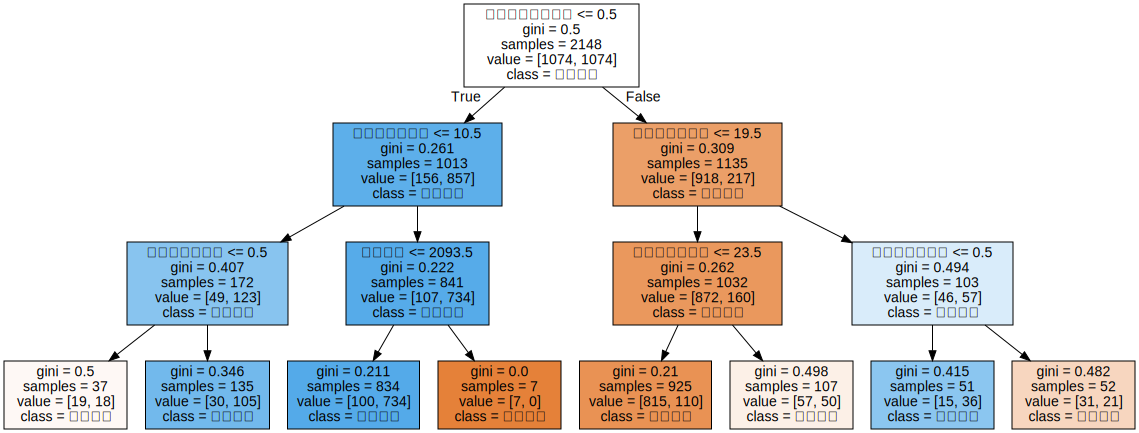

In [ ]:
graph = graphviz.Source(tree.export_graphviz(clf, feature_names=feature_names, class_names=['受取あり', '受取なし'], filled=True))
graph

## データの可視化

ここでは、決定木の可視化から得られた示唆を元にして、今回用いたオンライン予約データをいくつかの切り口で可視化しています。

### 受け取り x 地域内からの注文

In [ ]:
_wk = online_orders.groupby(['地域内からの注文'])['受け取りなし'].agg({'sum', 'count'})
_wk['rate'] = _wk.apply(lambda row: round(row['sum'] / row['count'], 2), axis=1)
_wk

sum  count  rate
地域内からの注文                  
0          65    221  0.29
1          53    971  0.05

### 受け取り x 合計金額

- この箱ひげ図からは、「受け取りなし」が 0 （予約して商品を受け取った）の場合は、1 の場合（予約したが商品を受け取らなかった）に比べて、高額な注文（一人以上の注文と思しき）の割合が多いことがわかります。

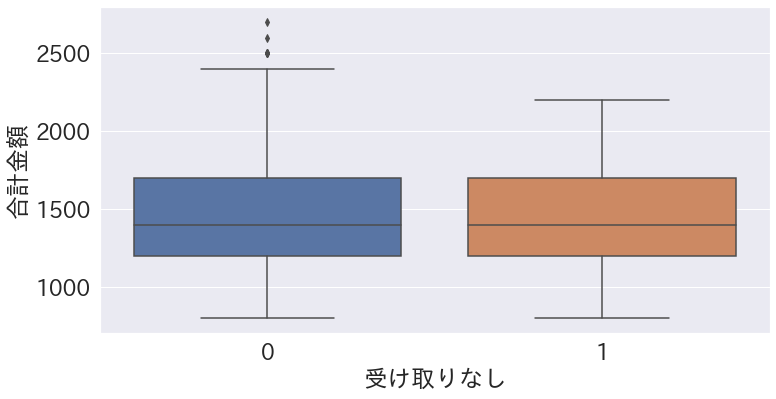

In [ ]:
sns.boxplot(data=online_orders, x='受け取りなし', y='合計金額')

### 受け取り x 予約注文時間差

- この箱ひげ図からは、「受け取りなし」が 1 の場合（予約したが商品を受け取らなかった）が、0 の場合（予約して商品を受け取った）に比べて、注文をした時間から、商品を取りに来る予約の時間までが長いことがわかります。

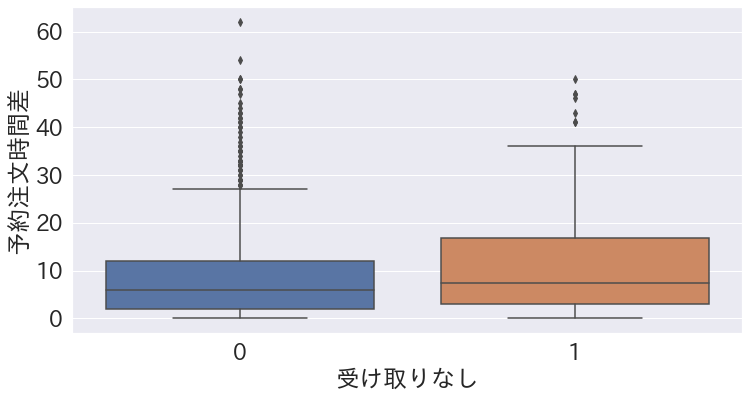

In [ ]:
sns.boxplot(data=online_orders, x='受け取りなし', y='予約注文時間差')

### 受け取り x 予約時間（時）

- この表からは、お店の閉店時間21時の直前の20時台には、商品の受け取りがない予約の割合が高いことがわかります。

In [ ]:
_wk = online_orders.groupby(['予約時間（時）'])['受け取りなし'].agg({'sum', 'count'})
_wk['rate'] = _wk.apply(lambda row: round(row['sum'] / row['count'], 2), axis=1)
_wk.columns = ['受け取りなし件数', '注文件数合計', '受け取りなしの割合']
_wk

受け取りなし件数  注文件数合計  受け取りなしの割合
予約時間（時）                             
7               4      73       0.05
8               7      72       0.10
9               4      73       0.05
10              7      81       0.09
11              7      71       0.10
12              8      87       0.09
13              6     102       0.06
14             10      94       0.11
15              8      97       0.08
16              6      91       0.07
17              8      98       0.08
18              7      85       0.08
19              9      90       0.10
20             27      78       0.35

## 無断キャンセルを予測してみよう！

### 注文１

- 予約曜日が平日
  - 1（平日）
- 予約時間（時）
  - 18
- 合計金額
  - 2200
- 地域内からの注文
  - 1（Yes）
- 予約注文時間差
  - 6

In [ ]:
clf.predict([[1, 18, 2200, 1, 6]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([0])

結果が 0 （array[] の内部の数値）なので、無断キャンセルの可能性は低いと予測できる。

### 注文２

- 予約曜日が平日
  - 1（平日）
- 予約時間（時）
  - 16
- 合計金額
  - 1300
- 地域内からの注文
  - 0（No）
- 予約注文時間差
  - 4

In [ ]:
clf.predict([[1, 16, 1300, 0, 4]])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  "X does not have valid feature names, but"


array([1])

結果が 1 なので、無断キャンセルの可能性は高いと予測できる。